# CPI index forecasting

**Author:** Joana Simões, joanasimoes@student.dei.uc.pt

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.signal as scs
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as st
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from utils import * 

# recurrent model
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

## Introduction

This notebook presents an analysis of the CPI Index from Norway from 1990 until the most recent update (August, 2022). 

NOTE: Throughout the analysis, a significance level of 95% was chosen for all the tests developed.

## Read data

In [3]:
df = pd.read_csv(os.path.join('CPITimeSeries', 'time_series_data.csv'), index_col='Date')

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
# select data from 1990 until now
df = df.loc[df.index >= '1990-01-01']

## Select the data from Norway

In [6]:
country = 'Norway'

## Add European Union CPI Index

In [7]:
european_union_countries_in_1990 = [
    "Belgium",
    "Denmark",
    "France",
    "Germany",
    "Greece",
    "Ireland",
    "Italy",
    "Luxembourg",
    "Netherlands, The",
    "Portugal",
    "Spain",
    "United Kingdom"
]

In [8]:
df['European Union'] = df[european_union_countries_in_1990].mean(axis=1)

## Time series overview 

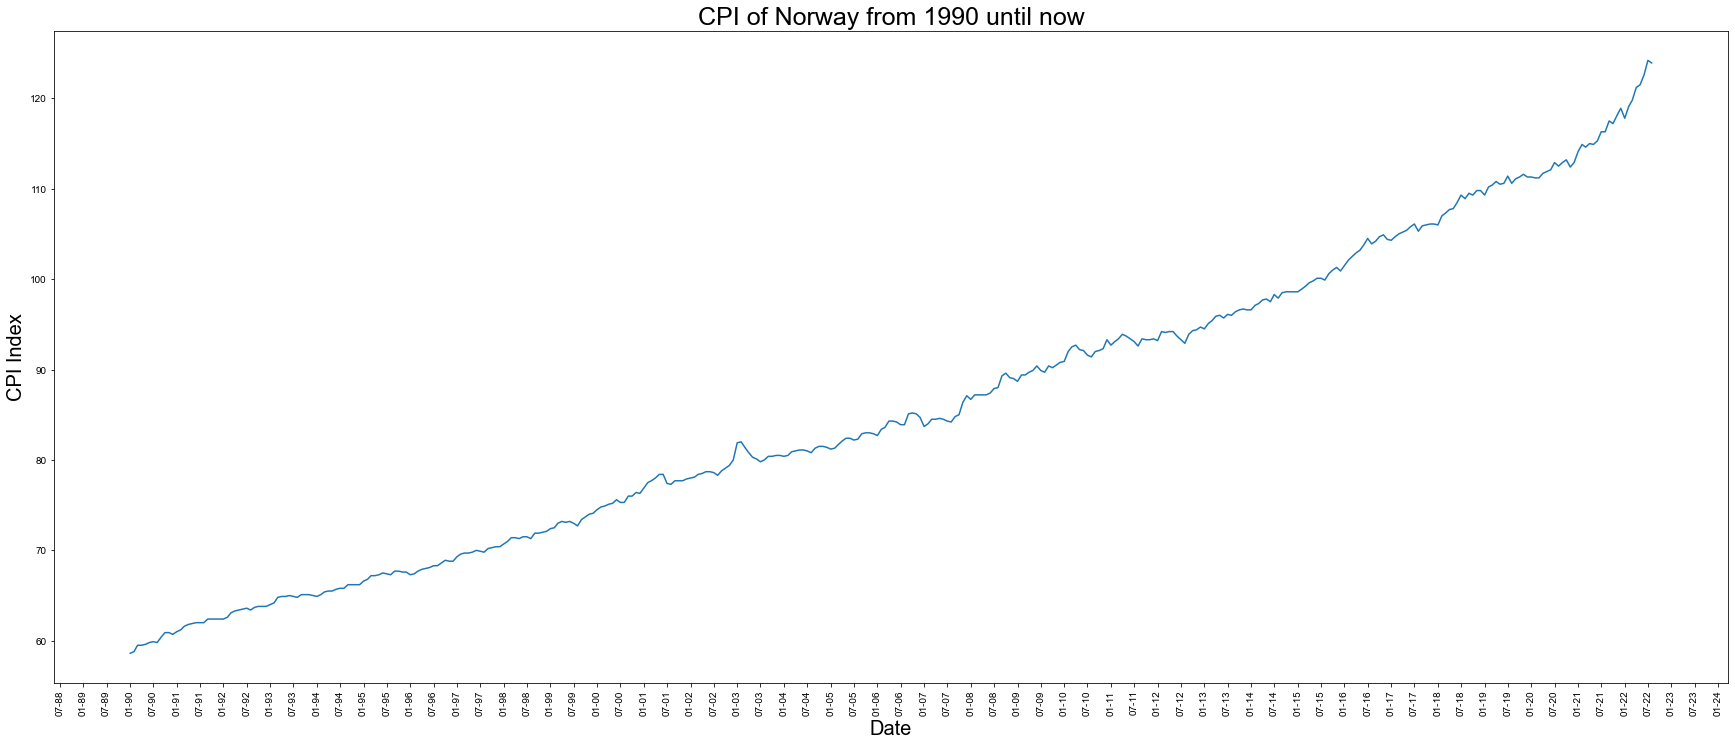

In [9]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.set(font_scale=1.5, style="whitegrid")
plt.plot(df.index, df[country])

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
plt.title(f'CPI of {country} from 1990 until now', fontdict=dict(size=25))
plt.savefig(os.path.join('images', 'original-ts.png'))
plt.show()


In a first analysis of the time series (TS), it's clearly seen a increasing trend of the CPI values over time. On a closer look, the TS appears to have a repetition (seasonality) every 6 months. With the increasing trend and seasonality every 6-months, it can be concluded that the original TS is not stationary. Therefore, it should be transformed to become stationary in order to apply forecasting models.

From the TS, it can also be concluded that there is and rapid increasing in the last 2-3 years, which will impact the final results as this exponential increasing is just the final part of the TS

### Period

In [10]:
period = 12

## Divide the time series into train and test

In [11]:
ts_stationary = df[country].diff().diff(period)

In [9]:
train_ratio = 0.8
split_index = int(len(df) * train_ratio)

# Split the time series data
train_data = df[:split_index]
test_data = df[split_index:]
months_dates = months = np.arange(len(df))
months = months_dates[:split_index]
months_test = months_dates[split_index:]

In [13]:
stationary_ts_train = ts_stationary[:split_index].dropna()
stationary_ts_test = ts_stationary[split_index:]

In [10]:
ts = train_data[country]
ts_test = test_data[country]

## Linear models for stationary Time series

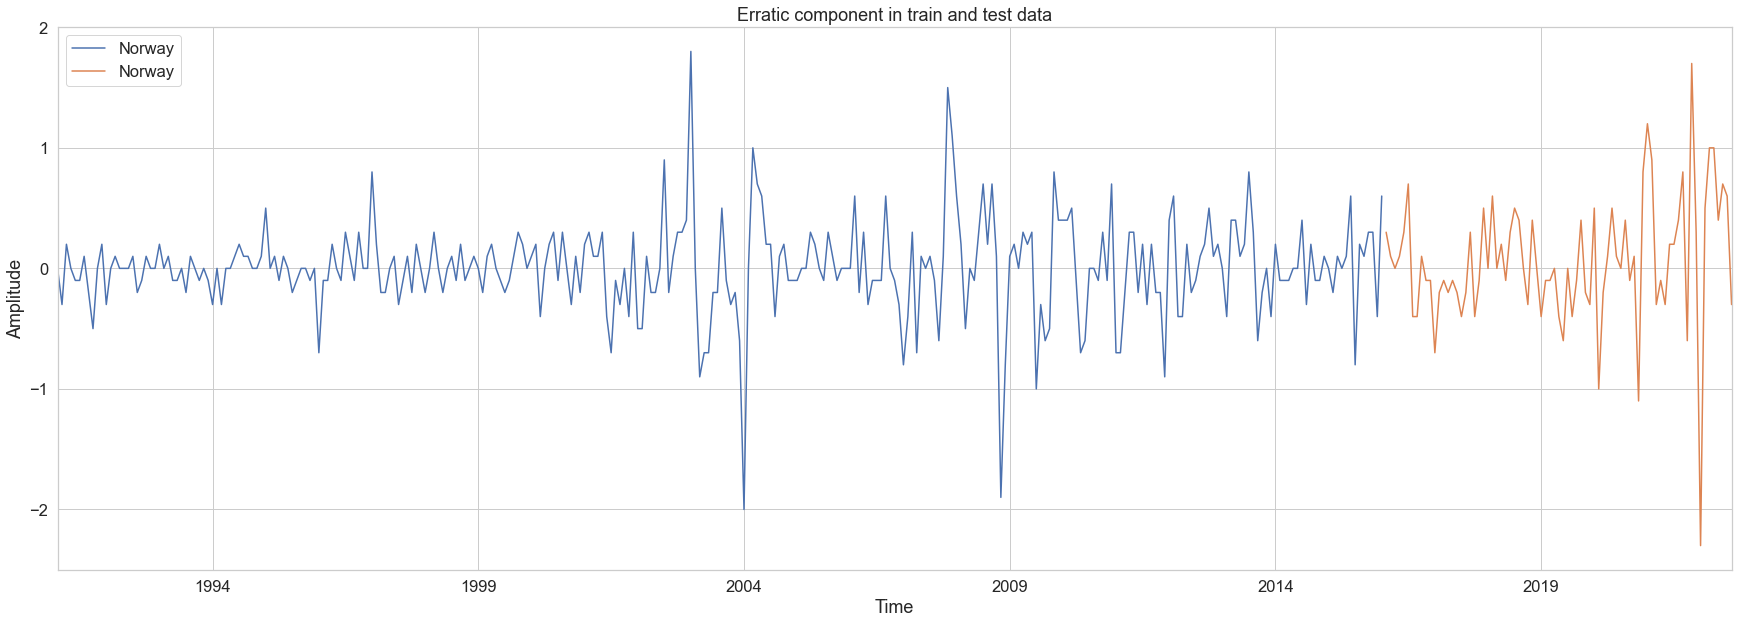

In [16]:
fig, ax = plt.subplots(figsize=(30, 10))
stationary_ts_train.plot(ax=ax, legend=True)
stationary_ts_test.plot(ax=ax, legend=True)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Erratic component in train and test data')
plt.savefig(os.path.join('images', 'train_test_erratic.png'))

### Trend and seasonal adjusted by model-fitting and filtering

In [17]:
adf_test(stationary_ts_train)

ADF Statistic: -7.240584
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


Based on the ADF test, given the p-value of 0.0, the transformed TS is stationary.

### Trend and seasonal adjusted test

In [18]:
adf_test(stationary_ts_test)

ADF Statistic: -2.990176
p-value: 0.035822
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


By the Dickey-Fuller test, after differencing the resulted TS is stationary. However, the ADF statistic most closer to the critical values than when the TS is decomposed by model-fitting and filtering. 

### ACS to see stationary

In [19]:
def auto_covarience_aux(ts, T=0):
    N = len(ts)
    mean = ts.mean()
    cov_coef = 0
    for n in range(N-T-1): ## Não estaremos a retirar um a mais
        cov_coef += (ts[n] - mean) * (ts[n+T]-mean)
    return cov_coef / N


def auto_covarience(ts, T=0):
    return auto_covarience_aux(ts, T) / auto_covarience_aux(ts)


def correlogram(ts, max_T, twoside=False):
    N = len(ts)
    if twoside:
        corrl = np.zeros(2 * max_T + 1)
        index = np.arange(max_T + 1)
        index = np.concatenate((-np.flip(index[1:]), index), axis=0)
    else:
        corrl = np.zeros(max_T)
        index = np.arange(max_T)

    for i in range(max_T):
        if twoside:
            corrl[max_T + i] = auto_covarience(ts, i)
            corrl[max_T - i] = corrl[max_T + 1]
        else:
            corrl[i] = auto_covarience(ts, i)
    
    d = {'ACS':corrl, 'upper_CB':np.ones(max_T)*(1.96/np.sqrt(N)),'lower_CB':-np.ones(max_T)*(1.96/np.sqrt(N))}
    return pd.DataFrame(data=d, index=index)

In [20]:
def plot_correlogram(ts, title, period=12):
    corrl = correlogram(ts, len(ts))
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.stem(corrl.index, corrl.ACS, label='ACS')
    ax.plot(corrl.index, corrl.upper_CB, linestyle='--', color='r', linewidth=2, label='+/-1.96/sqrt(N)'),
    ax.plot(corrl.index, corrl.lower_CB, linestyle='--', color='r', linewidth=2),
    plt.title(title, fontdict=dict(size=25))
    plt.legend()
    ax.set_xlim([-0.5, period+0.5])
    plt.ylabel('Autocorrelation')
    plt.xlabel('T')

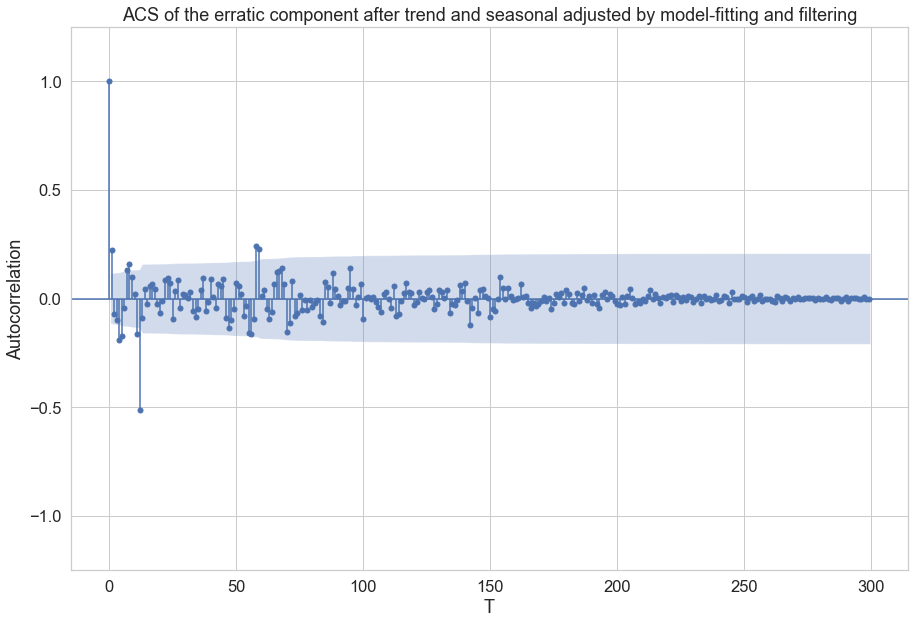

In [21]:
# plot_correlogram(trend_seasonal_adjusted, 'Erratic Component after trend and seasonality adjusted by model-fitting and filtering')
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(stationary_ts_train, alpha=0.05, ax=ax, lags=len(stationary_ts_train)-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
plt.title('ACS of the erratic component after trend and seasonal adjusted by model-fitting and filtering')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


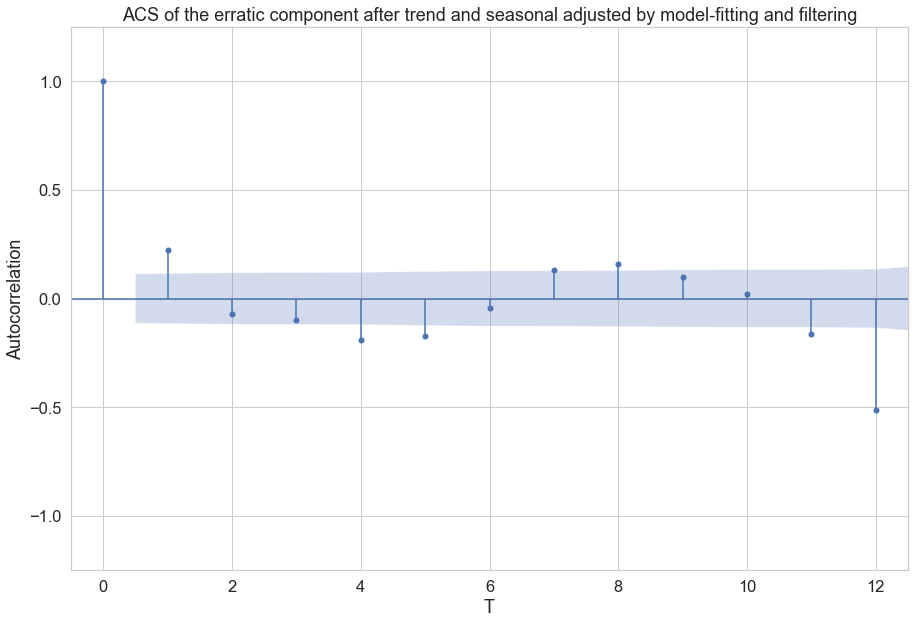

In [22]:
# plot_correlogram(trend_seasonal_adjusted, 'Erratic Component after trend and seasonality adjusted by model-fitting and filtering')
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(stationary_ts_train, alpha=0.05, ax=ax, lags=len(stationary_ts_train)-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([-0.5, period + 0.5])
plt.title('ACS of the erratic component after trend and seasonal adjusted by model-fitting and filtering')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


It can be seen that there is a rapid decreasing the the ACS, which indicates that the erratic component is stationary. 
Looking at the ACS for the first 12 lags (period=12), there are 2 significant value outside the unit root, therefore, a MA of order 2 can be used to describe the process.

### Assessing the underlying process of the stationary TS

#### PACS

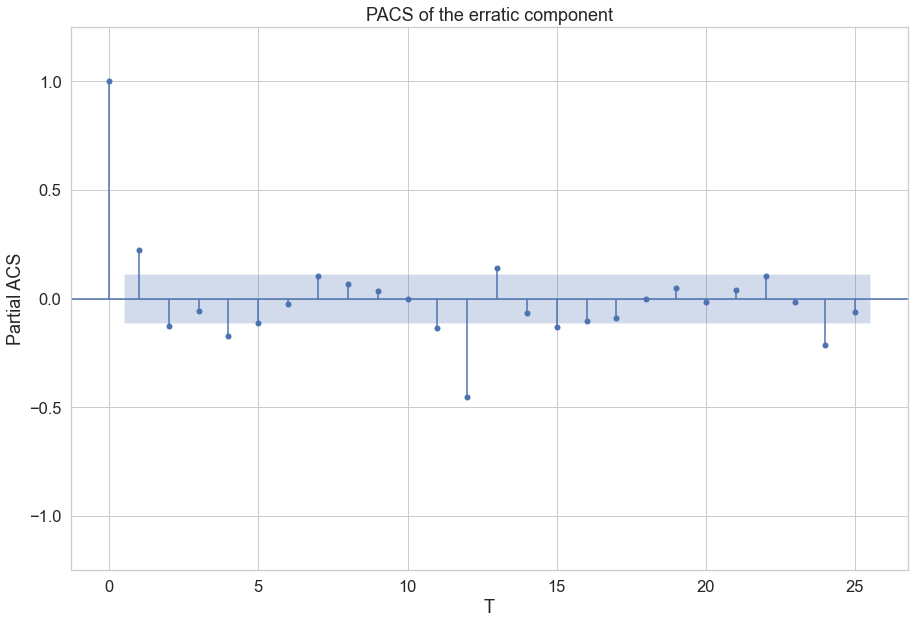

In [23]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(stationary_ts_train, alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS of the erratic component')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

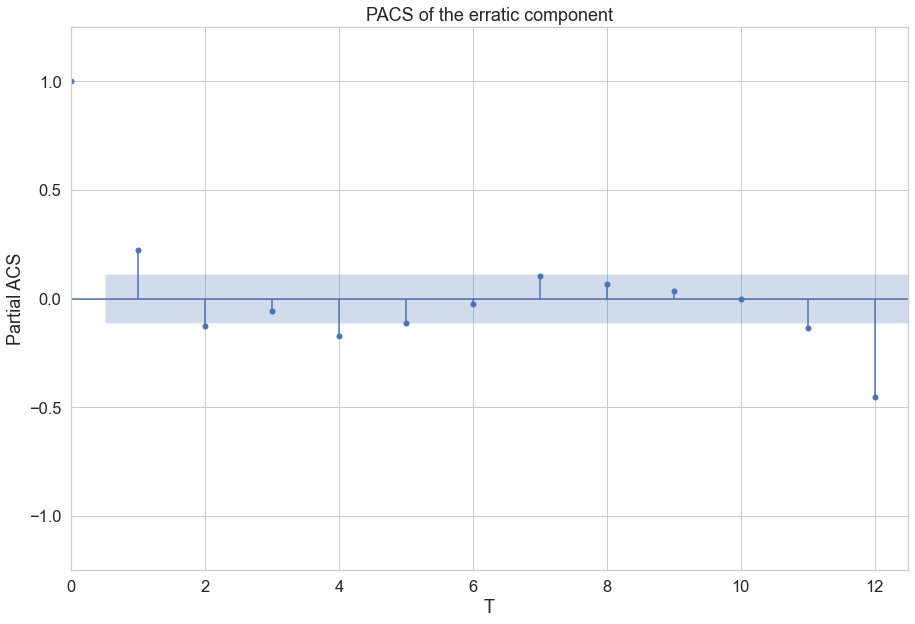

In [24]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(stationary_ts_train, alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([0, 12.5])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS of the erratic component')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

Looking at the PACS graph, it can be concluded that it should be use a AR model of order 6 from the problem, as there are clearly 6 significant autocorrelation values. 

In [25]:
def pacs(serie,max_lag=25):
    N=serie.size
    pcorrl=np.zeros(max_lag+1)
    ix=np.array(range(max_lag+1))
    pcorrl[0]=1
    for p in range(1,max_lag+1):
        model = ARIMA(serie, order=(p,0,0))
        model_fit = model.fit()
        pcorrl[p]=model_fit.arparams[-1]
        
    d = {'PACS':pcorrl, 'upsig':np.ones(max_lag+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(max_lag+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

In [26]:
pcorrl = pacs(stationary_ts_train)

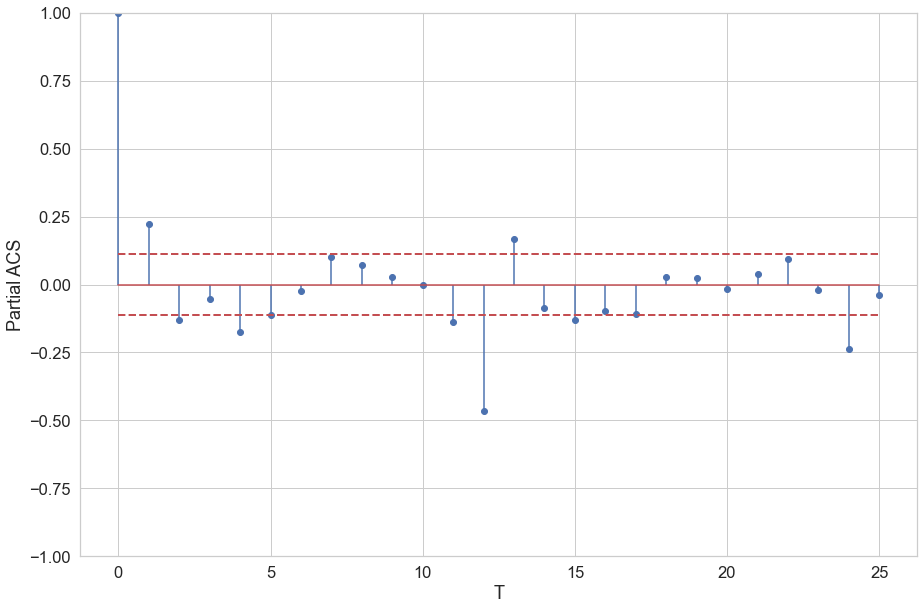

In [27]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.stem(pcorrl.index,pcorrl['PACS'])
ax.plot(pcorrl.index,pcorrl['upsig'],linestyle='--', color='r', linewidth=2)
ax.plot(pcorrl.index,pcorrl['dnsig'],linestyle='--', color='r', linewidth=2)
ax.set_ylim([-1, 1])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.show()

From the PACS plot, it can also be concluded that the time series presents a autoregressive component, concluding that should be use a ARMA model.

In order to find the best order for the model, it will be use grid search, varying the q order from 0 to 2 and the p order from 0 to 11. To evaluate the different models, it will be use the Akaike's Information Criterion (AIC) and Bayesian Information Criterion (BIC) metrics as using the residuals error does not penalize the complexity of the model.

### Looking for the best Linear model for stationary time series

In [28]:
max_q = 4
max_p = 4

In [29]:
residuals = pd.DataFrame(columns=['p', 'q', 'residual', 'aic', 'bic'])
for order_p in range(0,  max_p+1):
    for order_q in range(0,  max_q+1):
        model = ARIMA(stationary_ts_train, order=(order_p, 0, order_q))
        model_fit = model.fit()
        residual = np.sum(model_fit.resid**2)
        aux = {
            'p' : [order_p],
            'q' : [order_q],
            'residual' : [residual],
            'aic' : [model_fit.aic],
            'bic' : [model_fit.bic]
        }
        print('P-', order_p, '\tQ-', order_q, '\tResiduals-', residual, '\tAIC-', model_fit.aic, '\tBIC-', model_fit.bic)
        residuals = pd.concat([residuals, pd.DataFrame(aux)], ignore_index=True)
        

        

P- 0 	Q- 0 	Residuals- 44.28916667358771 	AIC- 281.45040838965366 	BIC- 288.8579733389661
P- 0 	Q- 1 	Residuals- 41.630057404268726 	AIC- 264.94632175686314 	BIC- 276.05766918083174
P- 0 	Q- 2 	Residuals- 41.483608088866006 	AIC- 265.88916558587965 	BIC- 280.7042954845044
P- 0 	Q- 3 	Residuals- 41.33009711759758 	AIC- 266.7841784137908 	BIC- 285.3030907870718
P- 0 	Q- 4 	Residuals- 40.58311127801609 	AIC- 263.3659391659437 	BIC- 285.58863401388095
P- 1 	Q- 0 	Residuals- 42.09397910946183 	AIC- 268.25070353814095 	BIC- 279.36205096210955
P- 1 	Q- 1 	Residuals- 41.51419993588624 	AIC- 266.1106728798744 	BIC- 280.92580277849925
P- 1 	Q- 2 	Residuals- 38.440724586565864 	AIC- 246.37642114648472 	BIC- 264.8953335197657
P- 1 	Q- 3 	Residuals- 38.404299482314286 	AIC- 248.11941361979564 	BIC- 270.3421084677328
P- 1 	Q- 4 	Residuals- 38.137685266454426 	AIC- 248.16301842859946 	BIC- 274.0894957511929
P- 2 	Q- 0 	Residuals- 41.39599312540633 	AIC- 265.25751770197496 	BIC- 280.0726476005998
P- 2

In [30]:
residuals

,p,q,residual,aic,bic
0,0,0,44.289167,281.450408,288.857973
1,0,1,41.630057,264.946322,276.057669
2,0,2,41.483608,265.889166,280.704295
3,0,3,41.330097,266.784178,285.303091
4,0,4,40.583111,263.365939,285.588634
5,1,0,42.093979,268.250704,279.362051
6,1,1,41.514200,266.110673,280.925803
7,1,2,38.440725,246.376421,264.895334
8,1,3,38.404299,248.119414,270.342108
9,1,4,38.137685,248.163018,274.089496


In [31]:
residuals.loc[(residuals.aic == residuals.aic.min())]

,p,q,residual,aic,bic
14,2,4,36.145145,234.83103,264.46129


In [32]:
lower_p = residuals.loc[residuals.p <= 6]

In [33]:
lower_p.loc[lower_p.aic == lower_p.aic.min()]

,p,q,residual,aic,bic
14,2,4,36.145145,234.83103,264.46129


In [34]:
best = residuals.loc[residuals.aic == residuals.aic.min()]
best

,p,q,residual,aic,bic
14,2,4,36.145145,234.83103,264.46129


In [35]:
best_p = best.p.values[0]
best_q = best.q.values[0]

In [36]:
model = ARIMA(stationary_ts_train, order=(best_p, 0, best_q))
model = model.fit()

In [37]:
for h in [3, 6, 12]:
    preds = get_predictions_from_horizon(
        model_fitted = model,
        forecast_horizon = h,
        ts = stationary_ts_train,
        ts_test = stationary_ts_test
    )
    reversed_preds = reverse_diff(ts, preds, split_index, period)
    print('\nFORECAST HORIZON:', h)
    metrics_summary(ts_test, reversed_preds)
    


FORECAST HORIZON: 3
MAPE: 0.010514784820015157
MAE: 1.1871961360582644
MSE: 2.5598431106277664
RMSE: 1.599950971319986
R2: 0.9117647758917181

FORECAST HORIZON: 6
MAPE: 0.010276146780927916
MAE: 1.1599107387973604
MSE: 2.449466743396495
RMSE: 1.565077232406278
R2: 0.9155693385457633

FORECAST HORIZON: 12
MAPE: 0.014837112586071594
MAE: 1.6729110613636782
MSE: 4.412636146689359
RMSE: 2.1006275602041784
R2: 0.8479008585741186


From testing different forecast horizons, it can be concluded that the best on is for 6 months.

In [38]:
preds = get_predictions_from_horizon(
        model_fitted = model,
        forecast_horizon = 6,
        ts = stationary_ts_train,
        ts_test = stationary_ts_test
    )
preds = reverse_diff(ts, preds, split_index, period)
preds.name = 'Predicted Test'

<Axes: xlabel='Date'>

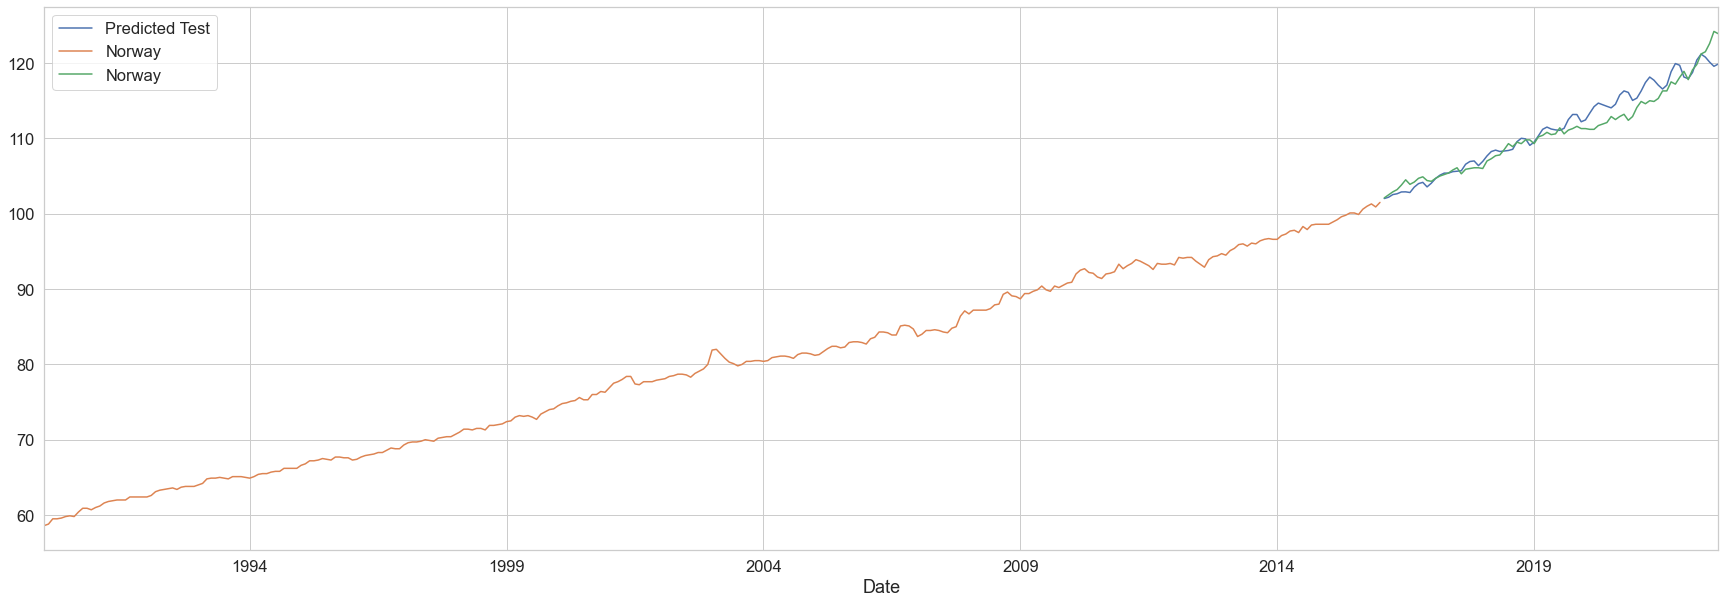

In [39]:
ax = preds.plot(figsize=(30, 10), legend=True)
ts.plot(ax=ax, legend=True)
ts_test.plot(ax=ax, legend=True)

In [40]:
metrics_summary(ts_test, preds)

MAPE: 0.010276146780927916
MAE: 1.1599107387973604
MSE: 2.449466743396495
RMSE: 1.565077232406278
R2: 0.9155693385457633


The results achieved by the ARIMA(2, 4) have a lower MAPE Error, indicating that the results are good. Looking for the graphic, it can be seen that the model has some difficulty in the final curve. This was previously imagined when doing the initial plot of the TS, because it follows a linear trend in the begin but the Out-Sample data has a curve.

## Linear models from non-stationary time series

For non-stationary time series, and since the TS has a seasonality, it will be use a SARIMA model. To found the best parameters of the model, it will be used grid-search and the models will be evaluated by the AIC and BIC values. 

### SARIMA model

(p, d, q) X (P, D, Q) S

S = seasonality period
d = for applying differencing - since it has a trend, use a d = 1
D = 1 -> apply first differencing for seasonal component based on the period

<Axes: title={'center': 'Original Train Data'}, xlabel='Date'>

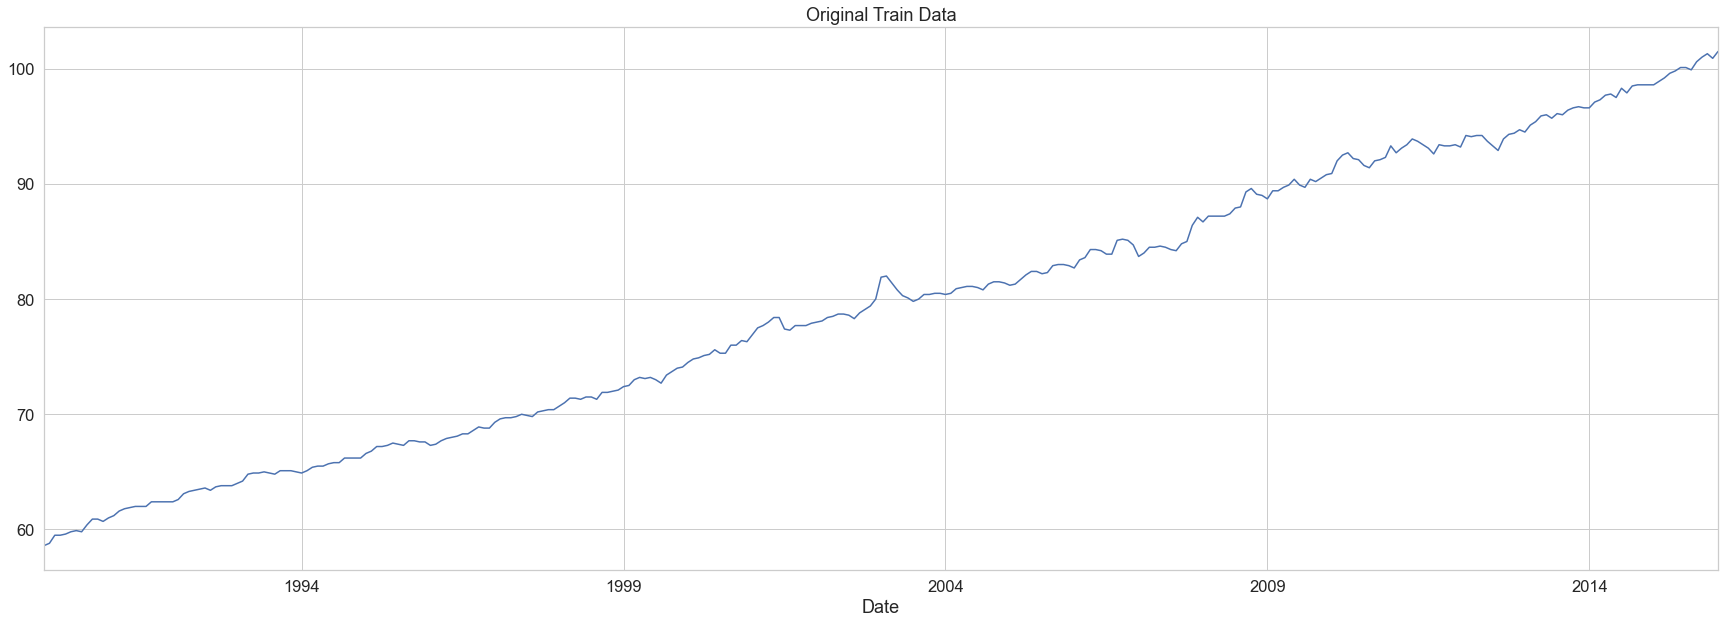

In [41]:
ts.plot(figsize=(30, 10), title='Original Train Data')

As there is a clear trend, it will be applied a first order simple differencing.

In [42]:
trend_diff_adjusted = ts.diff()

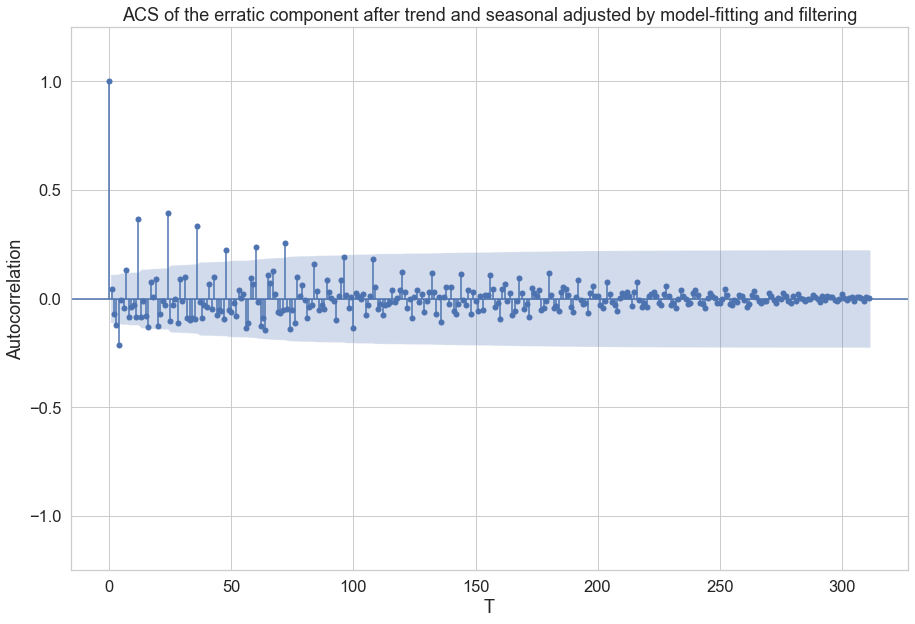

In [43]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(trend_diff_adjusted.dropna(), alpha=0.05, ax=ax, lags=len(trend_diff_adjusted.dropna())-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
plt.title('ACS of the erratic component after trend and seasonal adjusted by model-fitting and filtering')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


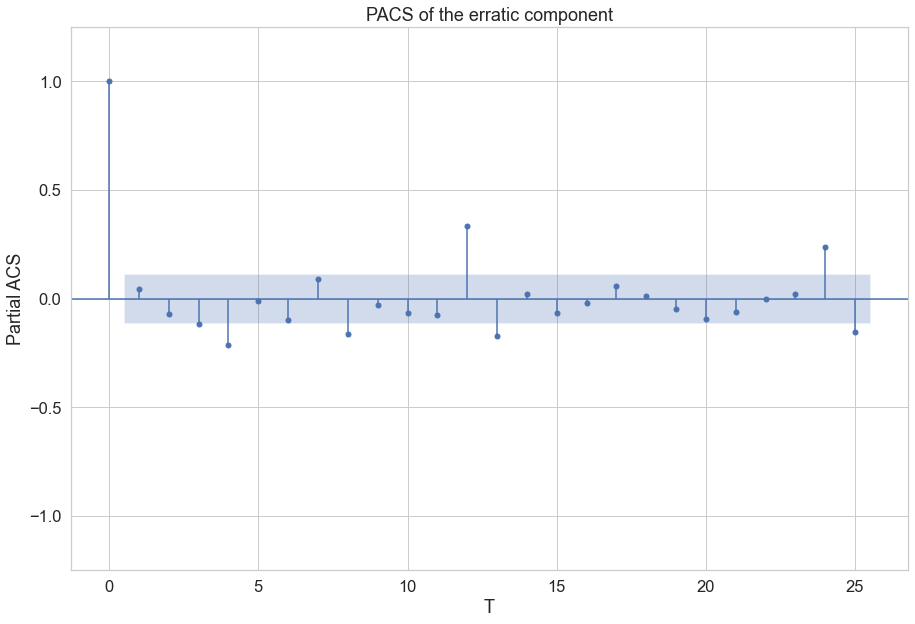

In [44]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(trend_diff_adjusted.dropna(), alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS of the erratic component')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

From the ACS it can be confirmed that seasonality is present, since there are ACS peaks at 12, 24, 36, etc. With this in mind, first-order seasonal differencing with S=12 will be applied as previously referenced. 

In [45]:
seasonal_adjusted = trend_diff_adjusted.diff(period)

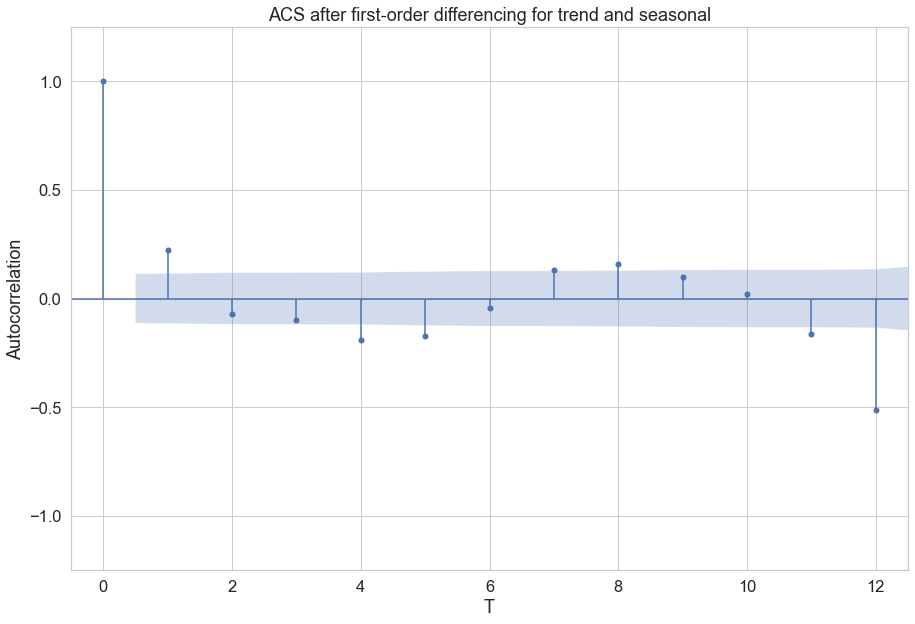

In [46]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(seasonal_adjusted.dropna(), alpha=0.05, ax=ax, lags=len(seasonal_adjusted.dropna())-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([-0.5, 0.5+period])
plt.title('ACS after first-order differencing for trend and seasonal')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


Looking at the ACS for T < 12, at lag 1, the ACS fall outside the unit root, meaning a q = 1.

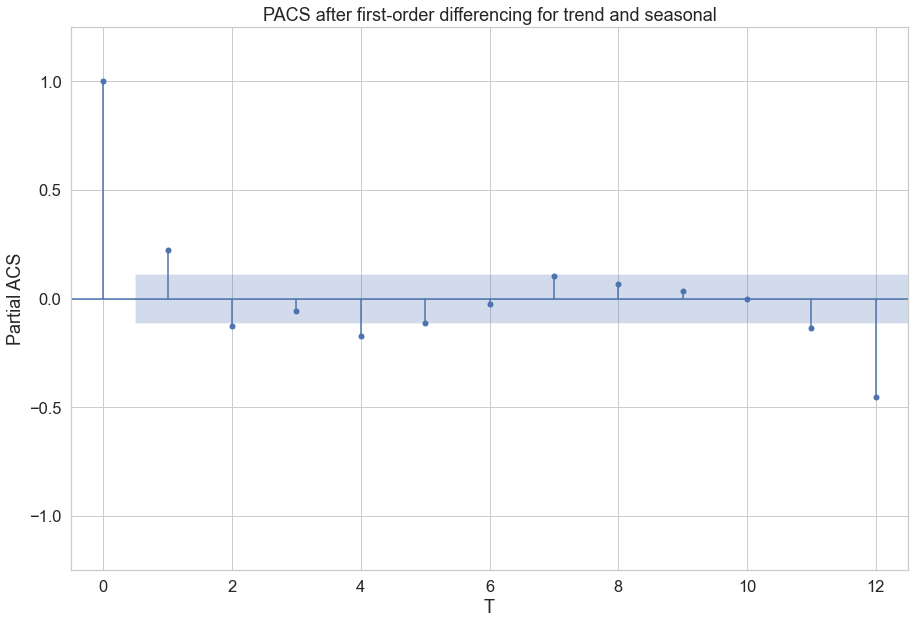

In [47]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(seasonal_adjusted.dropna(), alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([-0.5, 0.5+period])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS after first-order differencing for trend and seasonal')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

The first-order seasonal differencing seems appropriated to transform the TS into stationary, as previously seen in the ts-analysis notebook and confirmed by the ADF test. Therefore, a D=1 should be applied.
Looking at the PACS for T<12, for lag 1 and 2, the PACS fall out the unit root, so we can estimate as p=2.

Looking at the lags 12, 24, and 36, we can estimate the Q=1, as there is one significant value at lag 12.

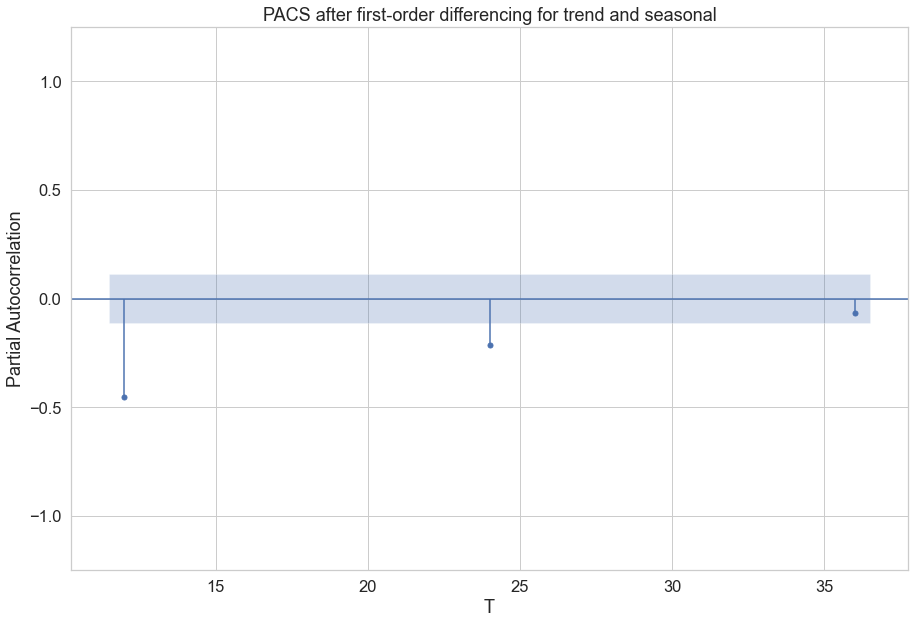

In [48]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(seasonal_adjusted.dropna(), alpha=0.05, ax=ax, lags=[12, 24, 36] )
plt.ylabel('Partial Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
plt.title('PACS after first-order differencing for trend and seasonal')
plt.show()

From the PACS for lags 12, 24, and 36, it can be estimated that P=2 as there is two significant values

With all values estimated, the SARIMA model must be :

(p, d, q) X (P, D, Q) S with
d = 1, D = 1, S = 12, p = 2, q = 1, Q = 1, P=2

In [49]:
d = 1
D = 1
S = period
p = 2
q = 1
Q = 1
P = 2

In [50]:
model = ARIMA(ts, order=(p, d, q), seasonal_order=(P, D, Q, S))
model_fitted = model.fit()

In [52]:
for h in [3, 6, 12]:
    print('\nForecast Horizon', h)
    preds = get_predictions_from_horizon(
        model_fitted,
        forecast_horizon=h,
        ts = ts, 
        ts_test = ts_test
    )
    metrics_summary(ts_test, preds)


Forecast Horizon 3
MAPE: 0.004867748233760922
MAE: 0.551450753701392
MSE: 0.668188152857302
RMSE: 0.8174277661404108
R2: 0.9769682246661576

Forecast Horizon 6
MAPE: 0.006550264462472748
MAE: 0.7476055871498042
MSE: 1.4266714005106793
RMSE: 1.1944335061068403
R2: 0.9508240679945166

Forecast Horizon 12
MAPE: 0.009009989469651548
MAE: 1.0244815227993638
MSE: 2.262407001450068
RMSE: 1.5041299815674403
R2: 0.9220171002010598


It can be seen that the best forecast horizon is at 3 months while using a SARIMA (p, d, q) X (P, D, Q) S with
d = 1, D = 1, S = 12, p = 2, q = 1, Q = 1, P=2

In [53]:
preds = get_predictions_from_horizon(
    model_fitted,
    forecast_horizon=3,
    ts = ts, 
    ts_test = ts_test
)

<Axes: xlabel='Date'>

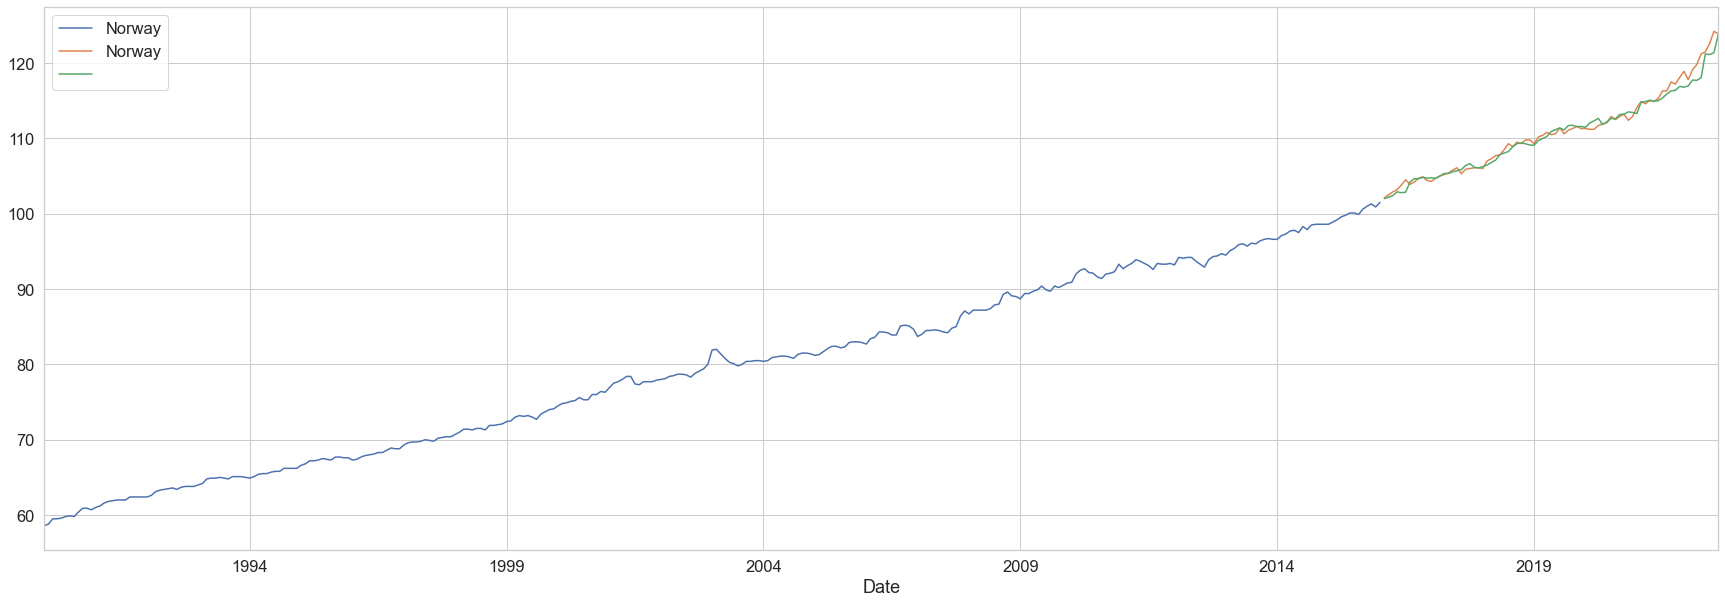

In [54]:
ax = ts.plot(figsize=(30, 10), legend=True)
ts_test.plot(ax=ax, legend=True)
preds.plot(ax=ax, legend=True)

In [55]:
metrics_summary(ts_test, preds)

MAPE: 0.004867748233760922
MAE: 0.551450753701392
MSE: 0.668188152857302
RMSE: 0.8174277661404108
R2: 0.9769682246661576


As the model may not have the best appropriate parameters, it will be used grid-search to find the best parameters. The evaluation will take into consideration the AIC wit the train data and the MAPE error in the validation set.

In [56]:
# split train data to evaluate the models
ts_train, ts_val, months_train, months_val = train_test_split(ts, months)

In [57]:
values_p = 5
values_q = 3
values_P = 4
values_Q = 2
D = 1
d = 1
S = period

In [242]:
results = pd.DataFrame()
count_models = 1
total_models = values_P * values_p * values_Q * values_q
for p in range(values_p):
    for q in range(values_q):
        for P in range(values_P):
            for Q in range(values_Q):
                print(count_models, ' out of ', total_models)
                print(p, q, P, Q)
                model = ARIMA(ts_train, order=(p, d, q), seasonal_order=(P, D, Q, S))
                model.initialize_approximate_diffuse()
                model_fitted = model.fit()
                preds = model_fitted.predict(start=len(ts_train), end=len(ts_train) + len(ts_val)-1)
                res = {
                    'd' : [d], 
                    'D' : D,
                    'S' : S,
                    'p' : p,
                    'q' : q,
                    'P' : P,
                    'Q' : Q,
                    'AIC' : model_fitted.aic,
                    'MAPE' : metrics.mean_absolute_percentage_error(ts_val, preds)

                }
                results = pd.concat([results, pd.DataFrame(res)], ignore_index=True)
                count_models += 1
results.to_csv('results_grid_ARIMA.csv', index=False)

1  out of  120
0 0 0 0
2  out of  120
0 0 0 1
3  out of  120
0 0 1 0
4  out of  120
0 0 1 1
5  out of  120
0 0 2 0
6  out of  120
0 0 2 1
7  out of  120
0 0 3 0
8  out of  120
0 0 3 1
9  out of  120
0 1 0 0
10  out of  120
0 1 0 1
11  out of  120
0 1 1 0
12  out of  120
0 1 1 1
13  out of  120
0 1 2 0
14  out of  120
0 1 2 1
15  out of  120
0 1 3 0
16  out of  120
0 1 3 1
17  out of  120
0 2 0 0
18  out of  120
0 2 0 1
19  out of  120
0 2 1 0
20  out of  120
0 2 1 1
21  out of  120
0 2 2 0
22  out of  120
0 2 2 1
23  out of  120
0 2 3 0
24  out of  120
0 2 3 1
25  out of  120
1 0 0 0
26  out of  120
1 0 0 1
27  out of  120
1 0 1 0
28  out of  120
1 0 1 1
29  out of  120
1 0 2 0
30  out of  120
1 0 2 1
31  out of  120
1 0 3 0
32  out of  120
1 0 3 1
33  out of  120
1 1 0 0
34  out of  120
1 1 0 1
35  out of  120
1 1 1 0
36  out of  120
1 1 1 1
37  out of  120
1 1 2 0
38  out of  120
1 1 2 1
39  out of  120
1 1 3 0
40  out of  120
1 1 3 1
41  out of  120
1 2 0 0
42  out of  120
1 2 0 1
4

In [244]:
results.loc[results.AIC == results.AIC.min()]

,d,D,S,p,q,P,Q,AIC,MAPE
9,1,1,12,0,1,0,1,1762.051898,0.149979


In [245]:
best = results.loc[results.MAPE == results.MAPE.min()]
best

,d,D,S,p,q,P,Q,AIC,MAPE
118,1,1,12,4,2,3,0,1995.274633,0.144232


From the grid-search the best SARIMA model is:

(p, d, q) X (P, D, Q) S with
d = 1, D = 1, S = 12, p = 2, q = 2, Q = 1, P=3

In [60]:
p = 4#best.p.values[0]
q = 2#best.q.values[0]
P = 3#best.P.values[0]
Q = 0#best.Q.values[0]

#### Re-train best model and test it on the test data

In [61]:
model = ARIMA(ts, order=(p, d, q), seasonal_order=(P, D, Q, S))
model.initialize_approximate_diffuse()
model_fitted = model.fit()

In [63]:
for h in [3, 6, 12]:
    print('\nForecast Horizon:', h)
    preds = get_predictions_from_horizon(
        model_fitted=model_fitted,
        forecast_horizon=h,
        ts=ts,
        ts_test=ts_test
    )
    metrics_summary(ts_test, preds)


Forecast Horizon: 3
MAPE: 0.004873835659738448
MAE: 0.5533269482453366
MSE: 0.6585123629811567
RMSE: 0.811487746661129
R2: 0.9773017394368878

Forecast Horizon: 6
MAPE: 0.006488141440914774
MAE: 0.7425027357577877
MSE: 1.3843466612087623
RMSE: 1.1765826197971658
R2: 0.9522829593000519

Forecast Horizon: 12
MAPE: 0.008874341970103783
MAE: 1.0088090667108347
MSE: 1.9869778191368939
RMSE: 1.409602007354166
R2: 0.9315108678177024


The best SARIMA model achieved the best perfornace using a forecast horizon of 3 months

In [64]:
preds = get_predictions_from_horizon(
        model_fitted=model_fitted,
        forecast_horizon=3,
        ts=ts,
        ts_test=ts_test
    )

Text(0, 0.5, 'CPI Index')

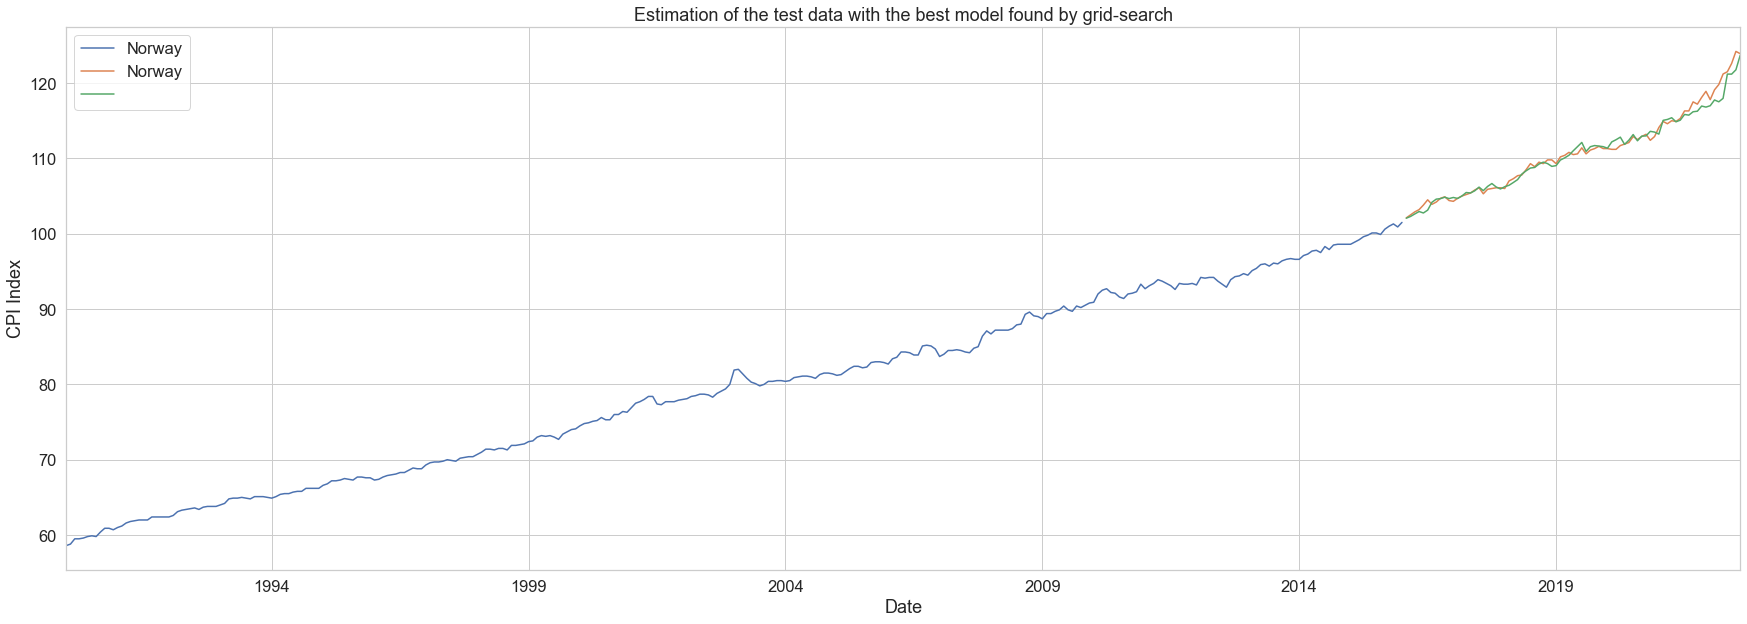

In [65]:
ax = ts.plot(figsize=(30, 10), legend=True)
ts_test.plot(ax=ax, legend=True)
preds.plot(ax=ax, legend=True)
ax.set_title('Estimation of the test data with the best model found by grid-search')
ax.set_xlabel('Date')
ax.set_ylabel('CPI Index')

In [66]:
metrics_summary(ts_test, preds)

MAPE: 0.004873835659738448
MAE: 0.5533269482453366
MSE: 0.6585123629811567
RMSE: 0.811487746661129
R2: 0.9773017394368878


In the prediction plot, it is concluded that the model has a good forecasting property. However, it still exists some error, as previously referenced, because the last 2/2.5 years, the CPI Index goes from more or less linear trend to a quadratic one. As this change only appears in the test data, the model will always have difficulty in forecasting.

From the metrics assessed, the model seems to also have a good forecasting power, as the result MAPE error is low and and the MAE error has a value of almost one, which is small for the range of values presented in the CPI Index. Additionally, the R Squared metric is nearly at 1, meaning that the forecasted values almost perfectly fit the data.

### Exponential Smoothing

In [67]:
alphas = np.arange(0.05, 1, 0.05)
gammas = np.arange(0.05, 1, 0.05)
deltas = np.arange(0.05, 1, 0.05)

In [252]:
results_es = pd.DataFrame()
count = 0
for alpha in alphas:
    for gamma in gammas:
        for delta in deltas:
            count += 1
            print(count, 'out of', len(alphas) * len(gammas) * len(deltas))
            model = ExponentialSmoothing(endog=ts_train, seasonal_periods=period, trend='additive', seasonal='additive', initialization_method='estimated')
            model_fitted = model.fit(
                smoothing_level=alpha,
                smoothing_trend=gamma,
                smoothing_seasonal=delta
            )
            preds = model_fitted.forecast(len(ts_val))
            mape = metrics.mean_absolute_percentage_error(ts_val, preds)
            res = {
                'alpha' : [alpha],
                'gamma' : gamma,
                'delta' : delta,
                'AIC' : model_fitted.aic,
                'MAPE' : mape
            }
            results_es = pd.concat([results_es, pd.DataFrame(res)], ignore_index=True)

results_es.to_csv('results_grid_es.csv', index=False)

1 out of 6859
2 out of 6859
3 out of 6859
4 out of 6859
5 out of 6859
6 out of 6859
7 out of 6859
8 out of 6859
9 out of 6859
10 out of 6859
11 out of 6859
12 out of 6859
13 out of 6859
14 out of 6859
15 out of 6859
16 out of 6859
17 out of 6859
18 out of 6859
19 out of 6859
20 out of 6859
21 out of 6859
22 out of 6859
23 out of 6859
24 out of 6859


25 out of 6859
26 out of 6859
27 out of 6859
28 out of 6859
29 out of 6859
30 out of 6859
31 out of 6859
32 out of 6859
33 out of 6859
34 out of 6859
35 out of 6859
36 out of 6859
37 out of 6859
38 out of 6859
39 out of 6859
40 out of 6859
41 out of 6859
42 out of 6859
43 out of 6859
44 out of 6859
45 out of 6859
46 out of 6859
47 out of 6859
48 out of 6859
49 out of 6859
50 out of 6859
51 out of 6859
52 out of 6859
53 out of 6859
54 out of 6859
55 out of 6859
56 out of 6859
57 out of 6859
58 out of 6859
59 out of 6859
60 out of 6859
61 out of 6859
62 out of 6859
63 out of 6859
64 out of 6859
65 out of 6859
66 out of 6859
67 out of 6859
68 out of 6859
69 out of 6859
70 out of 6859
71 out of 6859
72 out of 6859
73 out of 6859
74 out of 6859
75 out of 6859
76 out of 6859
77 out of 6859
78 out of 6859
79 out of 6859
80 out of 6859
81 out of 6859
82 out of 6859
83 out of 6859
84 out of 6859
85 out of 6859
86 out of 6859
87 out of 6859
88 out of 6859
89 out of 6859
90 out of 6859
91 out of 

In [253]:
best_es = results_es.loc[results_es.MAPE == results_es.MAPE.min()]
best_es

,alpha,gamma,delta,AIC,MAPE
255,0.05,0.7,0.45,1299.546618,0.145161


In [68]:
alpha = 0.05
gamma = 0.7
delta = 0.45

In [69]:
model = ExponentialSmoothing(endog=ts, seasonal_periods=period, trend='additive', seasonal='additive', initialization_method='estimated')
model_fitted = model.fit(
                smoothing_level=alpha,
                smoothing_trend=gamma,
                smoothing_seasonal=delta,
                optimized=True
            )

In [71]:
preds = model_fitted.forecast(len(ts_test))
preds.name = 'Predicted TS'

Text(0, 0.5, 'CPI Index')

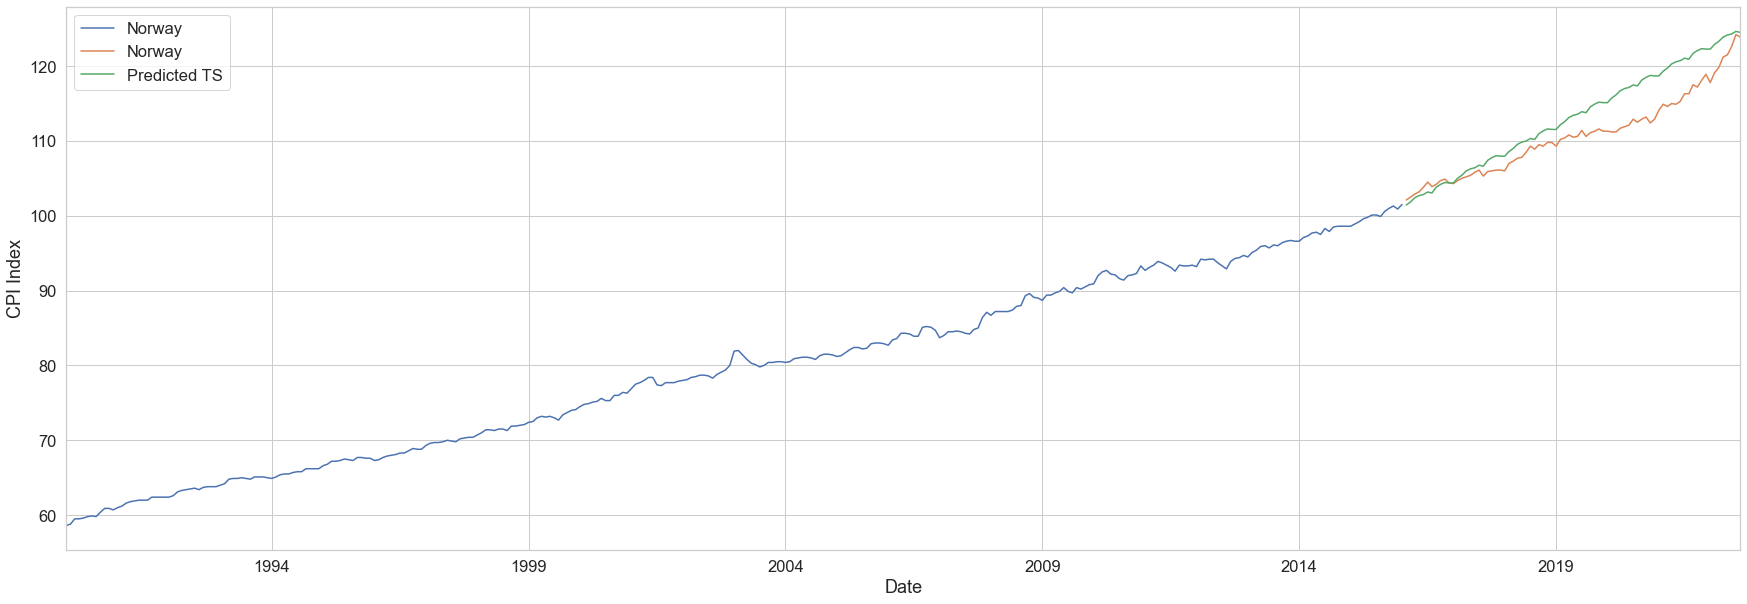

In [72]:
ax = ts.plot(figsize=(30, 10), legend=True)
ts_test.plot(ax=ax, legend=True)
preds.plot(ax=ax, legend=True)
ax.set_ylabel('CPI Index')

In [73]:
metrics_summary(ts_test, preds)

MAPE: 0.023680560615546496
MAE: 2.665777807176654
MSE: 10.211985703275278
RMSE: 3.1956197682570555
R2: 0.6480030969952324


From the exponential smoothing model's predictions image and the metrics attained, it is evident that the model has less predictive power than the SARIMA model. However, the metrics show that the model learns the data's major pattern, although not as much as the SARIMA model does.

## Multivariate TS

### Plot time series

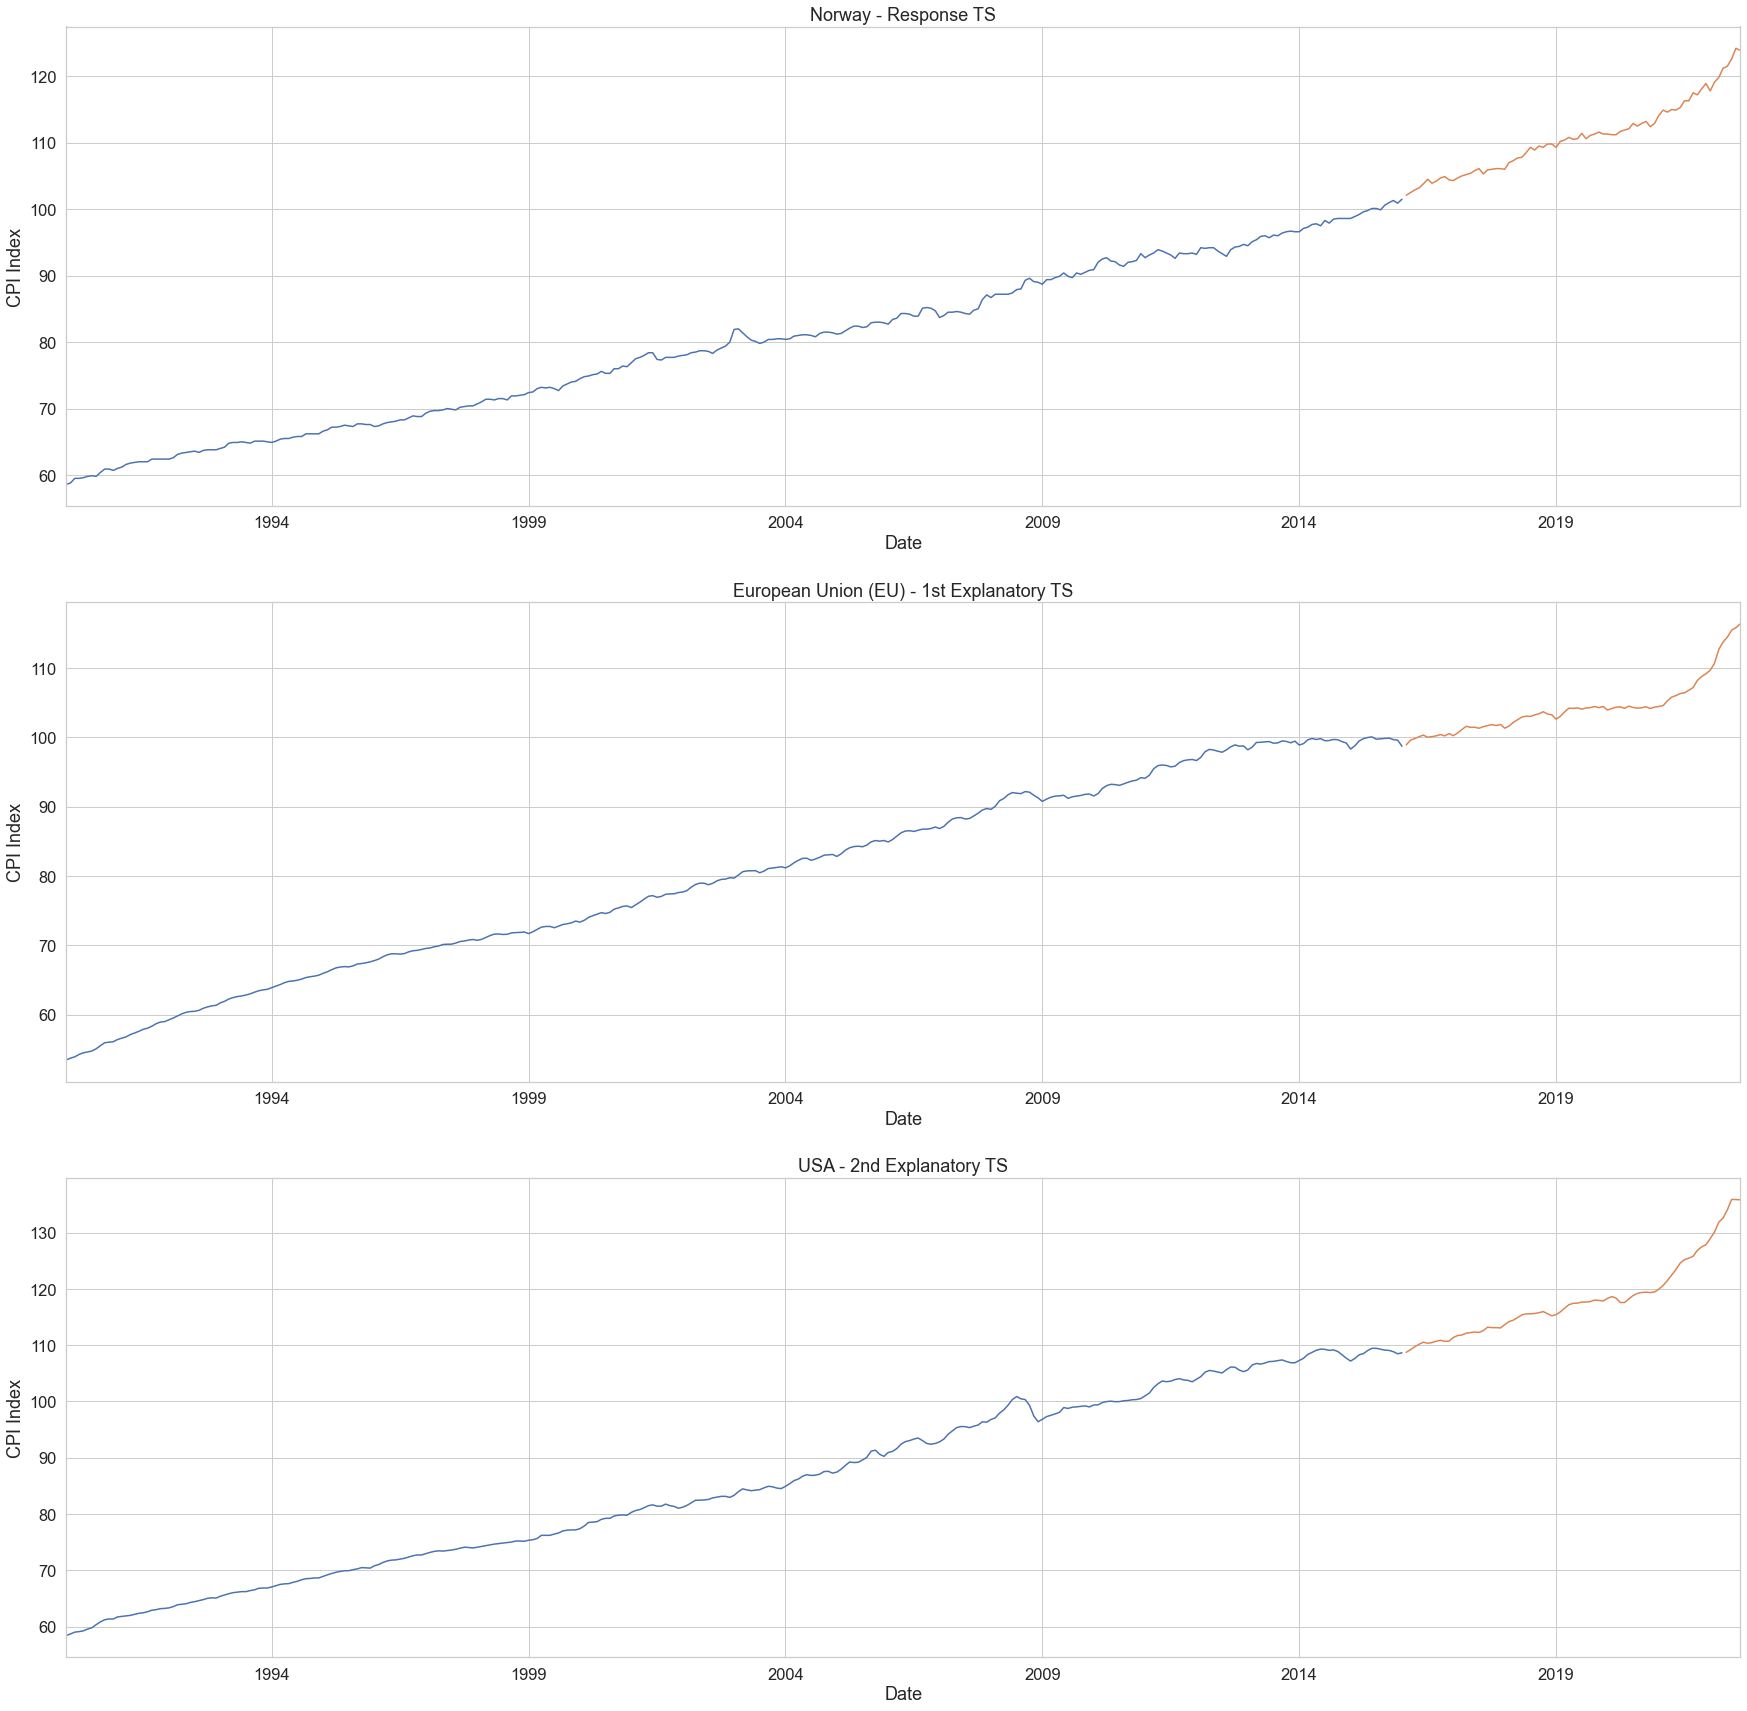

In [74]:
fig, axs = plt.subplots(3, figsize=(30, 30))

ts.plot(ax=axs[0])
ts_test.plot(ax=axs[0])
axs[0].set_ylabel('CPI Index')
axs[0].set_title('Norway - Response TS')

train_data['European Union'].plot(ax=axs[1])
test_data['European Union'].plot(ax=axs[1])
axs[1].set_ylabel('CPI Index')
axs[1].set_title('European Union (EU) - 1st Explanatory TS')

train_data['United States'].plot(ax=axs[2])
test_data['United States'].plot(ax=axs[2])
axs[2].set_ylabel('CPI Index')
axs[2].set_title('USA - 2nd Explanatory TS')

plt.show()

For the multivariate part of this work, it will be used the European Union (EU) CPI Index and the United States (USA) CPI Index. The European Union CPI Index was calculated using the mean of CPI Index of the countries that belong to it in 1990. 

Looking at the results achieved by the plot os the different Time Series, it is observed that the three TS are similar.

In [75]:
def crosscov(timeserie1,timeserie2,T=0):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    mu1=timeserie1.mean()
    mu2=timeserie2.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)
    return covCoef/float(np.abs(N))

In [76]:
def crosscoef(timeserie1,timeserie2,T=0):
    s1=timeserie1.std()
    s2=timeserie2.std()
    return crosscov(timeserie1,timeserie2,T)/(s1*s2)

In [77]:
def ccs(timeserie1,timeserie2,maxT,twoside=False):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            if i==0:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
            else:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
                corrl[maxT-i]=crosscoef(timeserie2,timeserie1,i);
        else:
            corrl[i]=crosscoef(timeserie1,timeserie2,i);
    d = {'CCS':corrl, 'Upper_Bound':np.ones(maxT+1)*(1.96/np.sqrt(N)),'Lower_Bound':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

In [78]:
ts_diff = ts.diff().diff(12)
eu_ts_diff = train_data['European Union'].diff().diff(12)
usa_ts_diff = train_data['United States'].diff().diff(12)

In [79]:
ts_names = ['Norway', 'EU', 'USA']
ts_values = [ts_diff.dropna(), eu_ts_diff.dropna(), usa_ts_diff.dropna()]

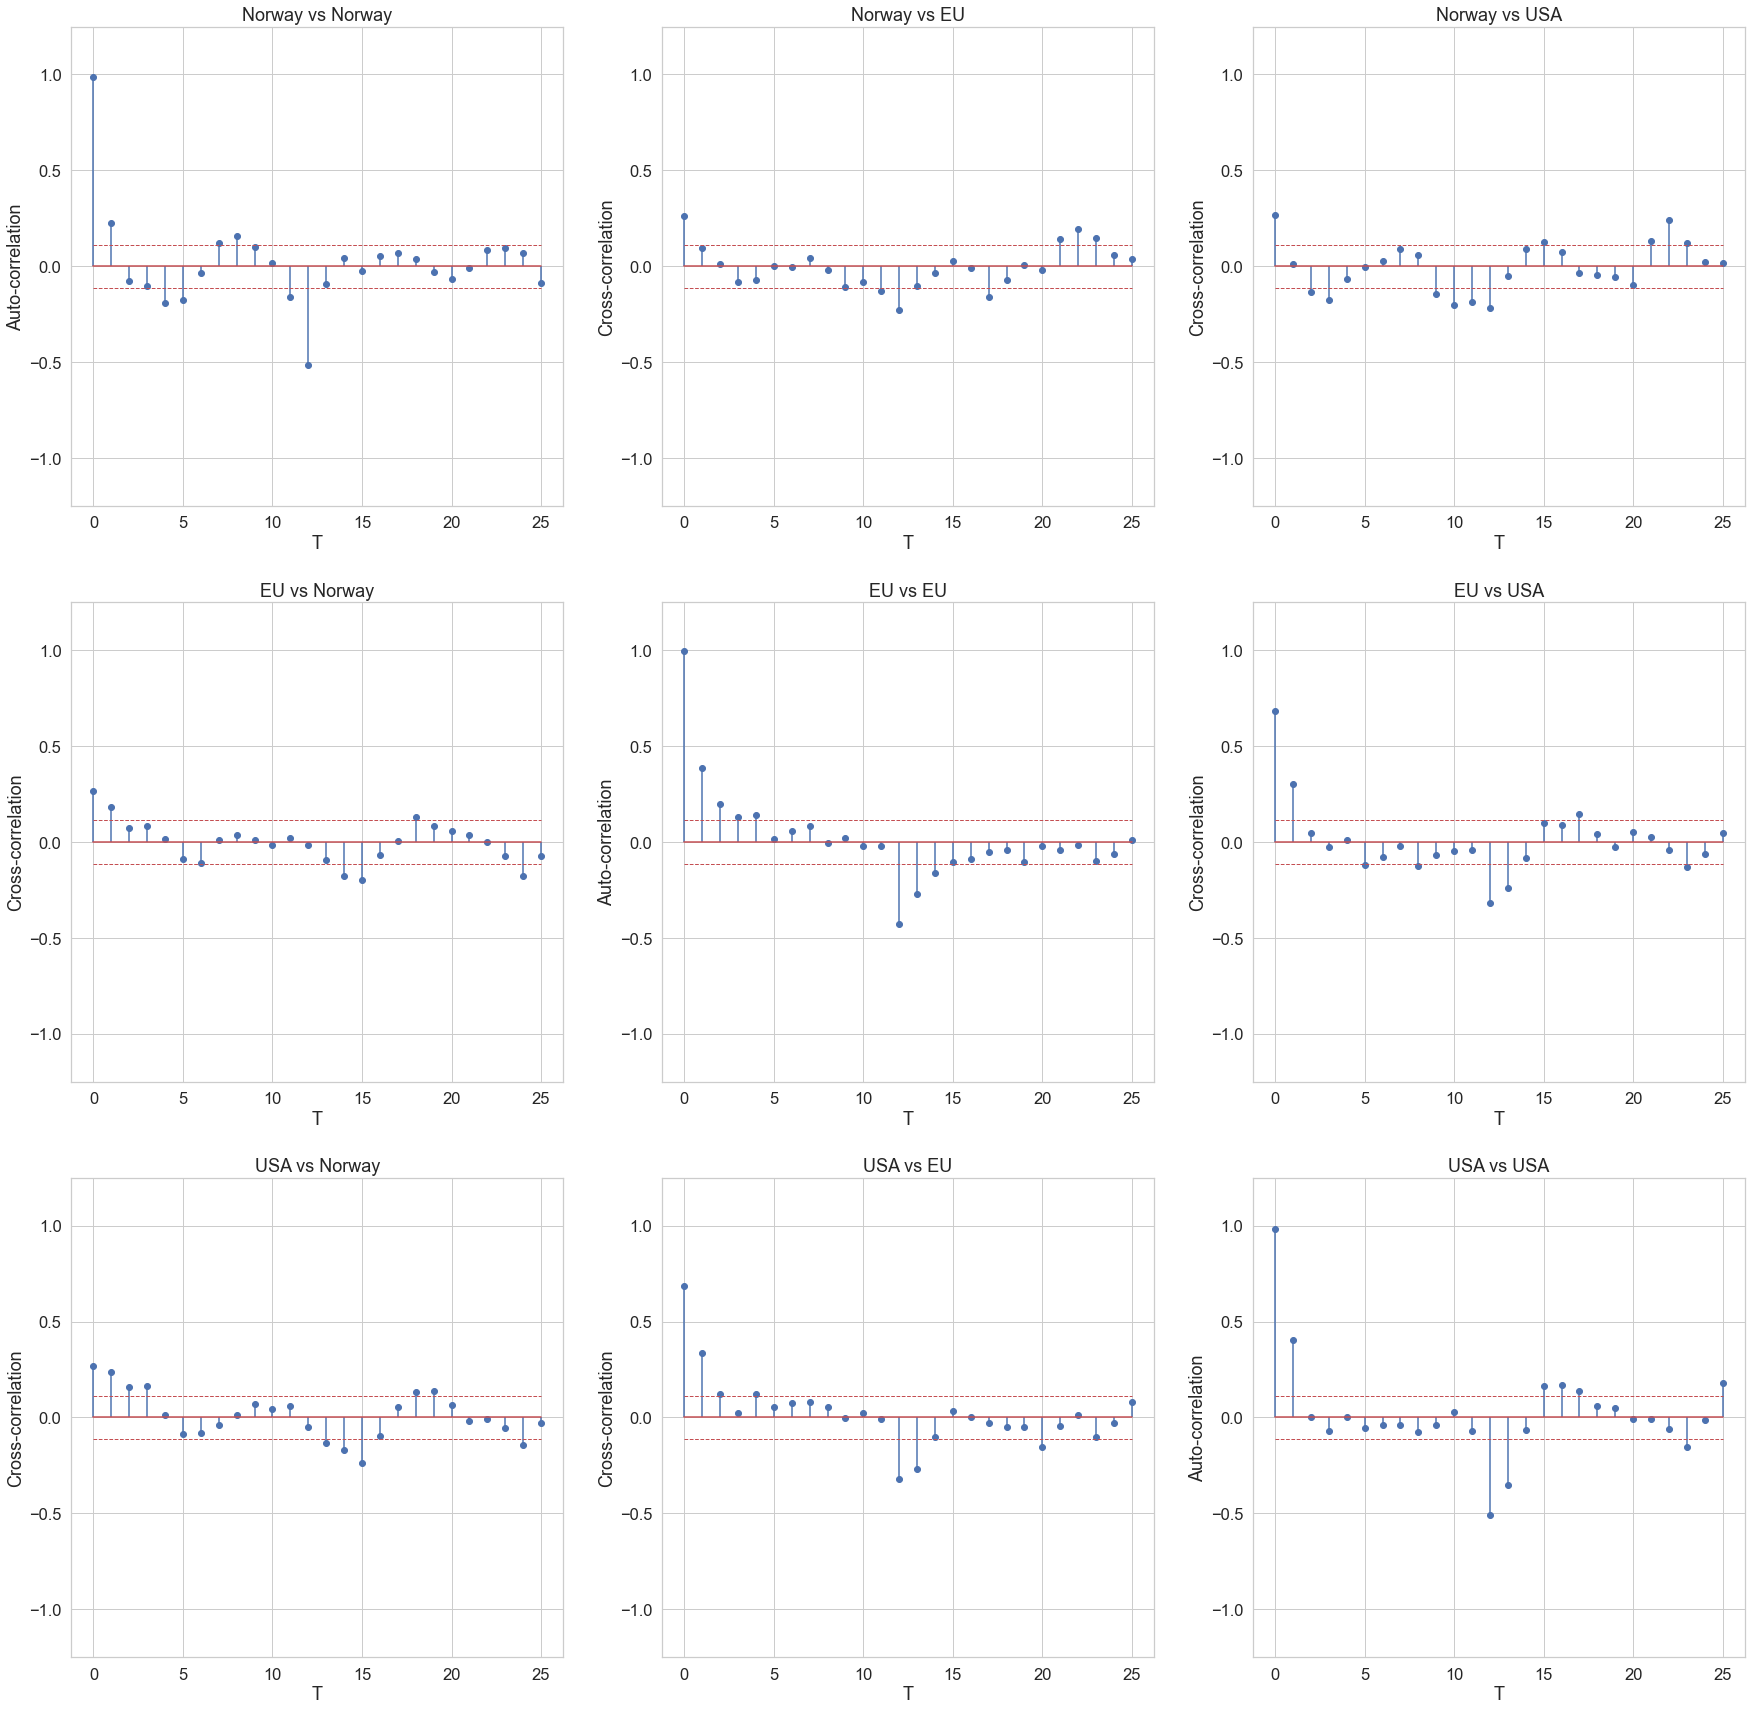

In [80]:
fig, axs = plt.subplots(len(ts_names), len(ts_names), figsize=(30, 30))

for i in range(len(ts_names)):
    for j in range(len(ts_names)):
        corrl = ccs(ts_values[i], ts_values[j], maxT=25)
        axs[i, j].stem(corrl.index, corrl.CCS)
        axs[i, j].plot(corrl.index, corrl.Upper_Bound, linestyle='--', color='r', linewidth=1)
        axs[i, j].plot(corrl.index, corrl.Lower_Bound, linestyle='--', color='r', linewidth=1)
        axs[i, j].set_xlabel('T')
        axs[i, j].set_ylim([-1.25, 1.25])
        if i == j:
            axs[i, j].set_ylabel('Auto-correlation')
        else:
            axs[i, j].set_ylabel('Cross-correlation')
        axs[i, j].set_title(f'{ts_names[i]} vs {ts_names[j]}')


From the cross-correlation plots, it is observed that there are few unidirectional relations between our TS of interest and the explanatory TS, except at the exact point that they are. 

Other relations appear when T=12, meaning that the CPI Index on the previous year for the EU and USA influence the TS in a point.
It was also found that for a given time point, the CPI index of USA in the previous 3 months influences the current time stamp.

### SARIMAX

As the value from the explanatory time series that most impact the results is at lag T=0, we will test a SARIMAX model for multivariate purpose, as it only uses the current value from the explanatory TS on the forecasting. Similar to the previous test, we will use grid-search to find the best parameters

In [87]:
tss_train, tss_val, month_train, months_val = train_test_split(train_data, months)

In [273]:
values_p = 5
values_q = 3
values_P = 4
values_Q = 2
D = 1
d = 1
S = period

In [90]:
explanatory_ts = ['United States', 'European Union']

In [275]:
results = pd.DataFrame()
count_models = 1
total_models = values_P * values_p * values_Q * values_q
for p in range(values_p):
    for q in range(values_q):
        for P in range(values_P):
            for Q in range(values_Q):
                print(count_models, ' out of ', total_models)
                print(p, q, P, Q)
                model = SARIMAX(tss_train[country], exog=tss_train[explanatory_ts], order=(p, d, q), seasonal_order=(P, D, Q, S))
                model.initialize_approximate_diffuse()
                model_fitted = model.fit(disp=False)
                preds = model_fitted.forecast(len(tss_val), exog=tss_val[explanatory_ts])
                res = {
                    'd' : [d], 
                    'D' : D,
                    'S' : S,
                    'p' : p,
                    'q' : q,
                    'P' : P,
                    'Q' : Q,
                    'AIC' : model_fitted.aic,
                    'MAPE' : metrics.mean_absolute_percentage_error(tss_val[country], preds)

                }
                results = pd.concat([results, pd.DataFrame(res)], ignore_index=True)
                count_models += 1

results.to_csv('results_grid_sarimax.csv', index=False)

1  out of  120
0 0 0 0
2  out of  120
0 0 0 1
3  out of  120
0 0 1 0
4  out of  120
0 0 1 1
5  out of  120
0 0 2 0
6  out of  120
0 0 2 1
7  out of  120
0 0 3 0
8  out of  120
0 0 3 1
9  out of  120
0 1 0 0
10  out of  120
0 1 0 1
11  out of  120
0 1 1 0
12  out of  120
0 1 1 1
13  out of  120
0 1 2 0
14  out of  120
0 1 2 1
15  out of  120
0 1 3 0
16  out of  120
0 1 3 1
17  out of  120
0 2 0 0
18  out of  120
0 2 0 1
19  out of  120
0 2 1 0
20  out of  120
0 2 1 1
21  out of  120
0 2 2 0
22  out of  120
0 2 2 1
23  out of  120
0 2 3 0
24  out of  120
0 2 3 1
25  out of  120
1 0 0 0
26  out of  120
1 0 0 1
27  out of  120
1 0 1 0
28  out of  120
1 0 1 1
29  out of  120
1 0 2 0
30  out of  120
1 0 2 1
31  out of  120
1 0 3 0
32  out of  120
1 0 3 1
33  out of  120
1 1 0 0
34  out of  120
1 1 0 1
35  out of  120
1 1 1 0
36  out of  120
1 1 1 1
37  out of  120
1 1 2 0
38  out of  120
1 1 2 1
39  out of  120
1 1 3 0
40  out of  120
1 1 3 1
41  out of  120
1 2 0 0
42  out of  120
1 2 0 1
4

In [276]:
best = results.loc[results.MAPE == results.MAPE.min()]
best

,d,D,S,p,q,P,Q,AIC,MAPE
27,1,1,12,1,0,1,1,854.650643,0.010268


In [88]:
p = 1#best.p.values[0]
q = 0#best.q.values[0]
P = 1#best.P.values[0]
Q = 1#best.Q.values[0]

In [91]:
model = SARIMAX(ts, exog=train_data[explanatory_ts], order=(p, d, q), seasonal_order=(P, D, Q, S))
fitted_model = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33158D-01    |proj g|=  8.78321D-01

At iterate    5    f=  1.98754D-01    |proj g|=  4.42110D-02


 This problem is unconstrained.



At iterate   10    f=  1.88973D-01    |proj g|=  5.75567D-02

At iterate   15    f=  1.87679D-01    |proj g|=  8.42842D-03

At iterate   20    f=  1.87454D-01    |proj g|=  5.79890D-03

At iterate   25    f=  1.87446D-01    |proj g|=  3.19483D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   3.195D-05   1.874D-01
  F =  0.18744644002996877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [92]:
for h in [3, 6, 12]:
    print('\nForecast Horizon:', h)
    preds = get_multi_predictions_from_horizon(
        fitted_model=fitted_model,
        train_data = train_data,
        test_data = test_data, 
        explanatory_ts=explanatory_ts,
        ts = ts,
        ts_test = ts_test,
        forecast_horizon=h
    )
    metrics_summary(ts_test, preds)


Forecast Horizon: 3
MAPE: 0.003972687111463143
MAE: 0.4416176768505722
MSE: 0.3281554452930404
RMSE: 0.5728485360835274
R2: 0.988688810990966

Forecast Horizon: 6
MAPE: 0.005493545223151229
MAE: 0.6145254742608667
MSE: 0.6732757500586829
RMSE: 0.8205338201796943
R2: 0.9767928602942659

Forecast Horizon: 12
MAPE: 0.006274985482756155
MAE: 0.7042573287135092
MSE: 0.89430519435119
RMSE: 0.945677108928407
R2: 0.9691741970759191


From the metrics, it can be concluded that the best SARIMAX model obtains the best results with a forecast horizon of 3 months

In [93]:
preds = get_multi_predictions_from_horizon(
        fitted_model=fitted_model,
        train_data = train_data,
        test_data = test_data, 
        explanatory_ts=explanatory_ts,
        ts = ts,
        ts_test = ts_test,
        forecast_horizon=3
    )
preds.name = 'Forecast'

Text(0, 0.5, 'CPI Index')

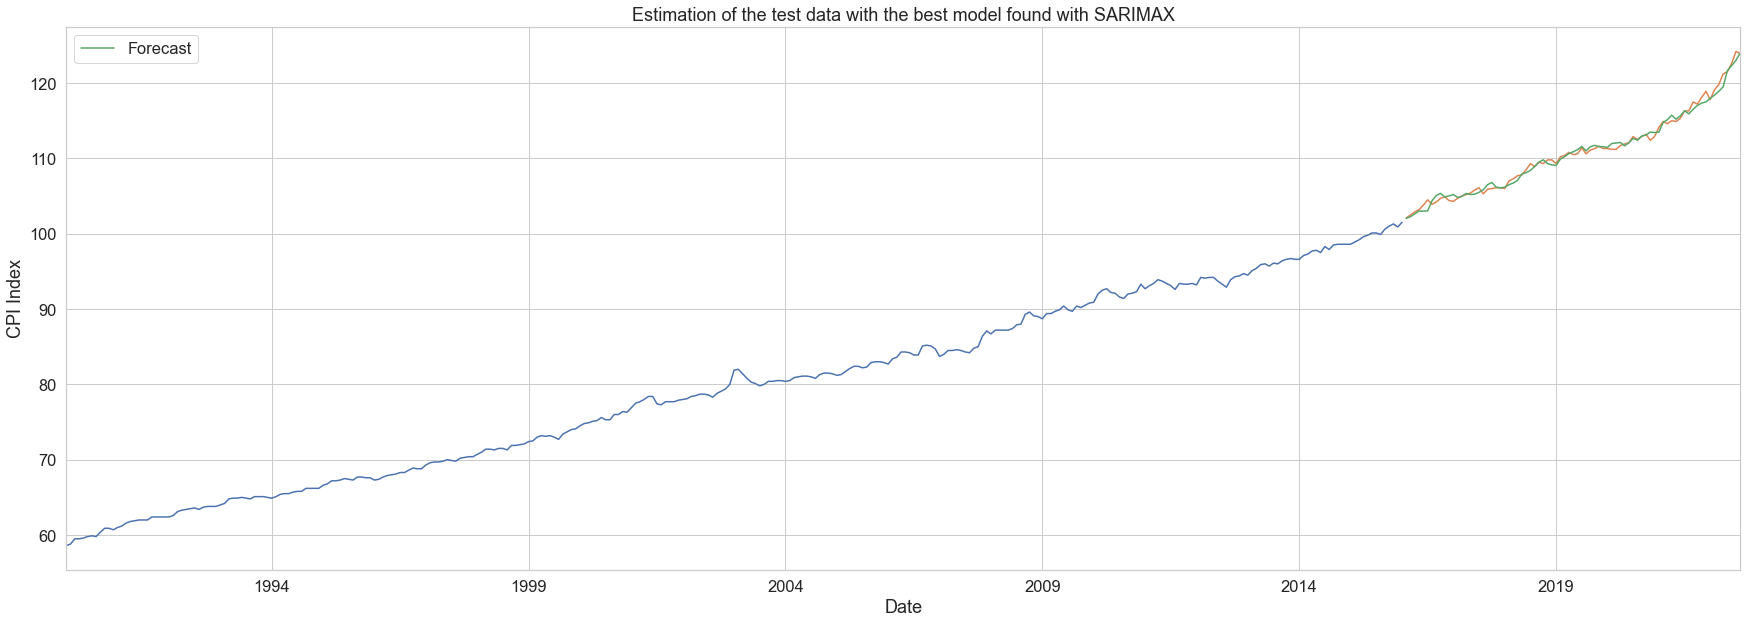

In [94]:
ax = ts.plot(figsize=(30, 10))
ts_test.plot(ax=ax)
preds.plot(ax=ax, legend=True)
ax.set_title('Estimation of the test data with the best model found with SARIMAX')
ax.set_xlabel('Date')
ax.set_ylabel('CPI Index')

In [95]:
metrics_summary(ts_test, preds)

MAPE: 0.003972687111463143
MAE: 0.4416176768505722
MSE: 0.3281554452930404
RMSE: 0.5728485360835274
R2: 0.988688810990966


After grid-search, it was found that the best model is 
(1, 1, 2) x (1, 1, 1, 12). 

From the results achieved by the the best model found with SARIMAX, it is concluded that it is the best model found so far, surpassing the ARIMA model.

### Vector Autoregressive (VAR) and Vector Autoregressive Moving Average (VARMA)

In [96]:
inputs = df[['Norway', 'United States', 'European Union']].copy()

In [97]:
for col in inputs.columns:
    inputs[col] = inputs[col].diff().diff(12)

In [98]:
train_multi_data = inputs[:split_index]
test_multi_data = inputs[split_index:]

Get the train data without the null values

In [99]:
train_multi_data = pd.DataFrame(train_multi_data.loc[train_multi_data.isnull().any(axis=1) == False])

In [100]:
x_train, x_val = train_test_split(train_multi_data)

In [101]:
values_orders = pd.DataFrame()
values = [
        (0, 1), (1, 0), (1, 1), (1, 2), (2, 1), (2, 2), (0, 2), (2, 0)
]
for (p,q) in values:
    model = VARMAX(x_train, order=(p, q))
    fitted_model = model.fit(maxiter=1000, disp=False)
    preds = fitted_model.forecast(len(x_val))[country]
    
    res = {
        'p' : [p],
        'q' : [q],
        'MAPE' : [metrics.mean_absolute_percentage_error(x_val[country], preds)],
        'AIC' : fitted_model.aic
    }
    print(res)
    values_orders = pd.concat([values_orders, pd.DataFrame(res)])

{'p': [0], 'q': [1], 'MAPE': [10431398963929.77], 'AIC': 73.33276143663471}
{'p': [1], 'q': [0], 'MAPE': [10465392587154.018], 'AIC': 73.2507694993819}
{'p': [1], 'q': [1], 'MAPE': [12716264785643.914], 'AIC': 75.64779435099508}
{'p': [1], 'q': [2], 'MAPE': [9847576056070.297], 'AIC': 86.71392235905523}
{'p': [2], 'q': [1], 'MAPE': [11999828573664.84], 'AIC': 86.2442718031567}
{'p': [2], 'q': [2], 'MAPE': [13573154163806.62], 'AIC': 91.193234208935}
{'p': [0], 'q': [2], 'MAPE': [10742067429571.768], 'AIC': 77.05480179398114}
{'p': [2], 'q': [0], 'MAPE': [10266403162227.549], 'AIC': 78.29777495784131}


In [102]:
best = values_orders.loc[values_orders.MAPE == values_orders.MAPE.min()]
best

,p,q,MAPE,AIC
0,1,2,9.847576e+12,86.713922


In [103]:
best_p = best.p.values[0]
best_q = best.q.values[0]

In [108]:
model = VARMAX(train_multi_data, order=(best_p, best_q))
fitted_model = model.fit(maxiter=1000, disp=False)

In [112]:
for h in [3, 6, 12]:
    print('Forecast Horizon:', h)
    preds = get_prediction_from_horizon_varmax(
        model_fitted = fitted_model,
        train_multi_data=train_multi_data,
        test_multi_data=test_multi_data,
        forecast_horizon=h
    )[country]
    preds = reverse_diff(ts, preds, split_index, period)
    metrics_summary(ts_test, preds)

Forecast Horizon: 3
MAPE: 0.08387650681026598
MAE: 9.608239294544932
MSE: 145.95949859704913
RMSE: 12.081369897368806
R2: -4.0310774968879794
Forecast Horizon: 6
MAPE: 0.07726561699069148
MAE: 8.844648049353983
MSE: 121.78780328412206
RMSE: 11.035751142723456
R2: -3.1979034073672397
Forecast Horizon: 12
MAPE: 0.03871535703582291
MAE: 4.458596563152331
MSE: 36.53296299920562
RMSE: 6.044250408380316
R2: -0.2592545864203213


The overall results are now great compared with the previously achieved. HOwever, from the results achieved the best forecast horizon for the VARMAX model is 1 year (12 months)

In [113]:
preds = get_prediction_from_horizon_varmax(
        model_fitted = fitted_model,
        train_multi_data=train_multi_data,
        test_multi_data=test_multi_data,
        forecast_horizon=12
    )
preds = preds.add_suffix(' [Predicted]')

In [114]:
predicted = preds['Norway [Predicted]']

In [115]:
predicted = reverse_diff(ts, predicted, split_index, period)

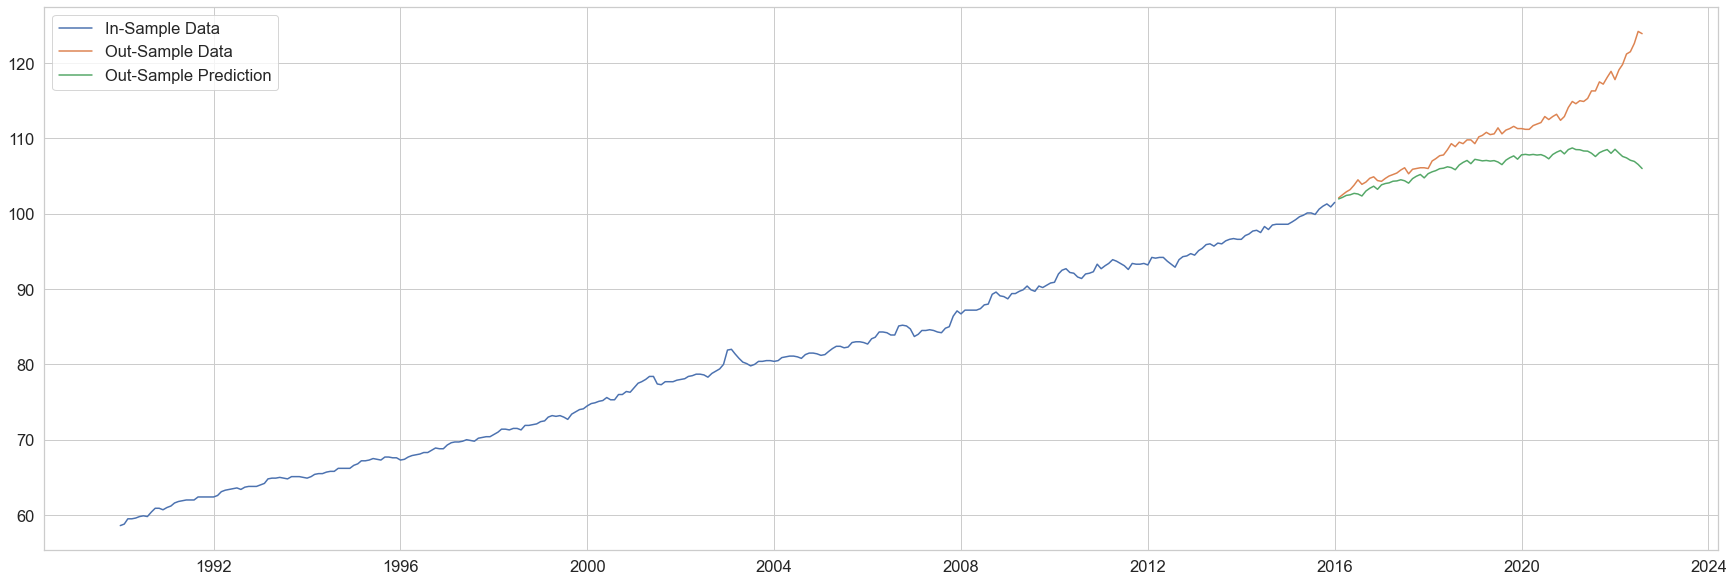

In [116]:
plt.figure(figsize=(30, 10))
plt.plot(ts.index, ts, label='In-Sample Data')
plt.plot(ts_test.index, ts_test, label='Out-Sample Data')
plt.plot(predicted.index, predicted, label='Out-Sample Prediction')
plt.legend()
plt.show()

In [117]:
metrics_summary(ts_test, predicted)

MAPE: 0.03871535703582291
MAE: 4.458596563152331
MSE: 36.53296299920562
RMSE: 6.044250408380316
R2: -0.2592545864203213


Even after doig a grid-search to find the best parameters for the VARMAX model, the results are poor, far below the results obtained with both SARIMA and SARIMAX.

## Machine Learning Models

In this section, it will be tested Machine Learning (ML) model to forecast the Norwegian CPI Index.

### Univariate model

#### Normalized data

In [158]:
x_train, x_val = train_test_split(ts, shuffle=False, test_size=0.15)

In [276]:
scaler_ts = MinMaxScaler()
normalized_train = pd.Series(scaler_ts.fit_transform(x_train.values.reshape(-1, 1)).reshape(-1, 1)[:, 0], index=x_train.index)
normalized_train.name = 'Normalized Train Data'
normalized_val = pd.Series(scaler_ts.transform(x_val.values.reshape(-1, 1)).reshape(-1, 1)[:, 0], index=x_val.index)
normalized_val.name = 'Normalized Validation Data'
normalized_test = pd.Series(scaler_ts.transform(ts_test.values.reshape(-1, 1)).reshape(-1, 1)[:, 0], index=ts_test.index)
normalized_test.name = 'Normalized Test Data'

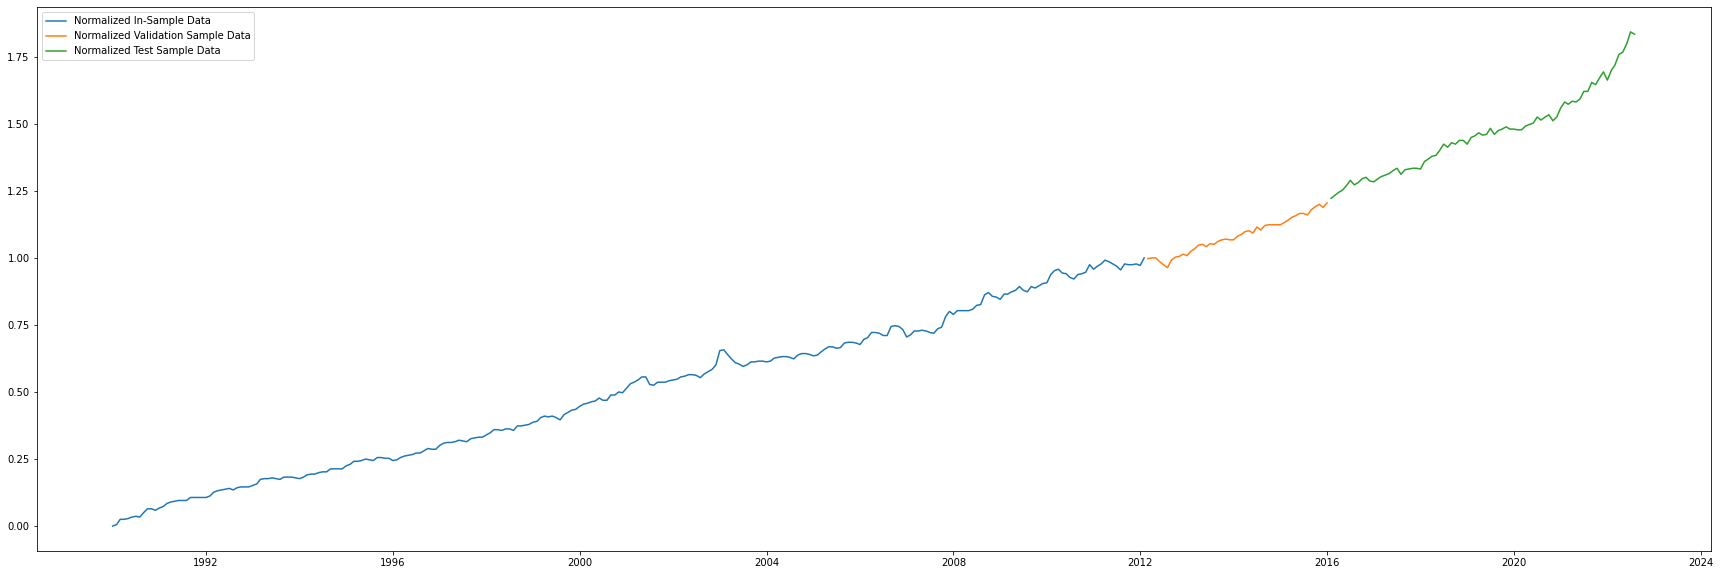

In [277]:
plt.figure(figsize=(30, 10))
plt.plot(normalized_train.index, normalized_train, label='Normalized In-Sample Data')
plt.plot(normalized_val.index, normalized_val, label='Normalized Validation Sample Data')
plt.plot(normalized_test.index, normalized_test, label='Normalized Test Sample Data')
plt.legend()
plt.show()

In [278]:
def generate_IO_data(outData,inData=pd.DataFrame(),delayEndog=[1],delayExog=[],h=1):
    N=outData.shape[0]
    inShape=inData.shape
    if len(inShape)==1:
        M=1
    else:
        M=inShape[1]# The number of explanatory TS (Exogenous inputs)
    
    laggedData=pd.DataFrame(index=inData.index)
    for i in range(M):
        for j in range(len(delayExog[i])):
            if isinstance(inData, pd.DataFrame):
                laggedData[inData.columns[i]+'_lag'+str(delayExog[i][j]+(h-1))] = inData[inData.columns[i]].shift(periods=delayExog[i][j]+(h-1))
            else:
                laggedData[inData.name+'_lag'+str(delayExog[i][j]+(h-1))] = inData.shift(periods=delayExog[i][j]+(h-1))
    
    for j in range(len(delayEndog)):
        laggedData[outData.name+'_lag'+str(delayEndog[j]+(h-1))] = outData.shift(periods=delayEndog[j]+(h-1))
    
    laggedData[outData.name]=outData
    
    return laggedData.dropna(axis=0)

In [279]:
def generate_tensor(data,T,M):
    dataMat=data.to_numpy()
    N=data.shape[0]
    Ti=0
    tensor=np.zeros((N,T,M))
    print(tensor.shape)
    for i in range(M):
        tensor[:,:,i]=dataMat[:,Ti:Ti+T]
        Ti=Ti+T
    
    return tensor

In [280]:
max_lag = 12
delays = range(1, max_lag+1)

In [281]:
# train data
train_delays = generate_IO_data(normalized_train, delayEndog=delays)
train_input = train_delays.iloc[:, 0:-1]
train_output = np.array([train_delays.iloc[:, -1].to_numpy()]).T 
train_input_tensor = generate_tensor(train_input, max_lag, 1)

(254, 12, 1)


In [282]:
# validation data
val = pd.concat([normalized_train.iloc[len(normalized_train)-max_lag:], normalized_val])
val.name = 'Validation'
val_delays = generate_IO_data(val, delayEndog=delays)
val_input = val_delays.iloc[:, 0:-1]
val_output = np.array([val_delays.iloc[:, -1].to_numpy()]).T 
val_input_tensor = generate_tensor(val_input, max_lag, 1)

(47, 12, 1)


In [283]:
test = pd.concat([normalized_val.iloc[len(normalized_val)-max_lag:], normalized_test])
test.name = 'Validation'
test_delays = generate_IO_data(test, delayEndog=delays)
test_input = test_delays.iloc[:, 0:-1]
test_output = np.array([test_delays.iloc[:, -1].to_numpy()]).T 
test_input_tensor = generate_tensor(test_input, max_lag, 1)

(79, 12, 1)


In [284]:
LATENT_DIM = 50
BATCH_SIZE = 8
EPOCHS = 50
HORIZON = 1

In [285]:
model = Sequential()
model.add(layers.GRU(LATENT_DIM, input_shape=(max_lag, 1)))
model.add(layers.Dense(HORIZON))

In [286]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 50)                7950      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [287]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

In [288]:
history = model.fit(
    train_input_tensor, 
    train_output,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (val_input_tensor, val_output),
    callbacks = [early_stopping],
    verbose = 1    
)

Epoch 1/50


32/32 [==============================] - 2s 32ms/step - loss: 0.0829 - val_loss: 0.0286
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 4.9909e-04
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 8.2613e-04 - val_loss: 0.0014
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 9.2350e-04 - val_loss: 8.2885e-04
Epoch 7/50
32/32 [==============================] - 0s 13ms/step - loss: 7.9737e-04 - val_loss: 4.4586e-04
Epoch 8/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 7.9051e-04
Epoch 9/50
32/32 [==============================] - 0s 14ms/step - loss: 6.9483e-04 - val_loss: 0.0046
Epoch 10/50
32/32 [==============================] - 0s 14ms/step - loss: 8.3083e-04 - v

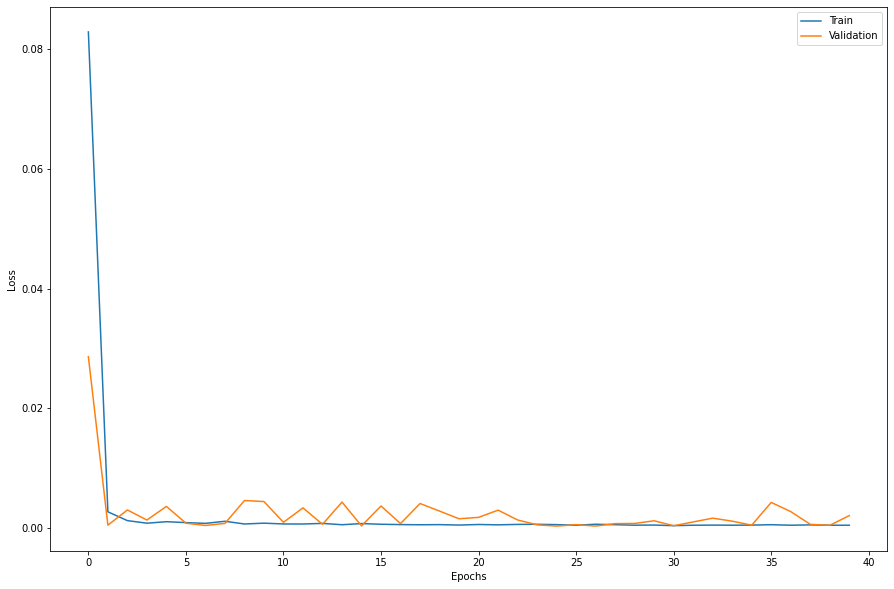

In [289]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [290]:
preds = model.predict(test_input_tensor)

3/3 [==============================] - 0s 14ms/step


In [291]:
preds = pd.Series(scaler.inverse_transform(preds)[:, 0], name='Test Predictions', index=ts_test.index)

ValueError: non-broadcastable output operand with shape (79,1) doesn't match the broadcast shape (79,191)

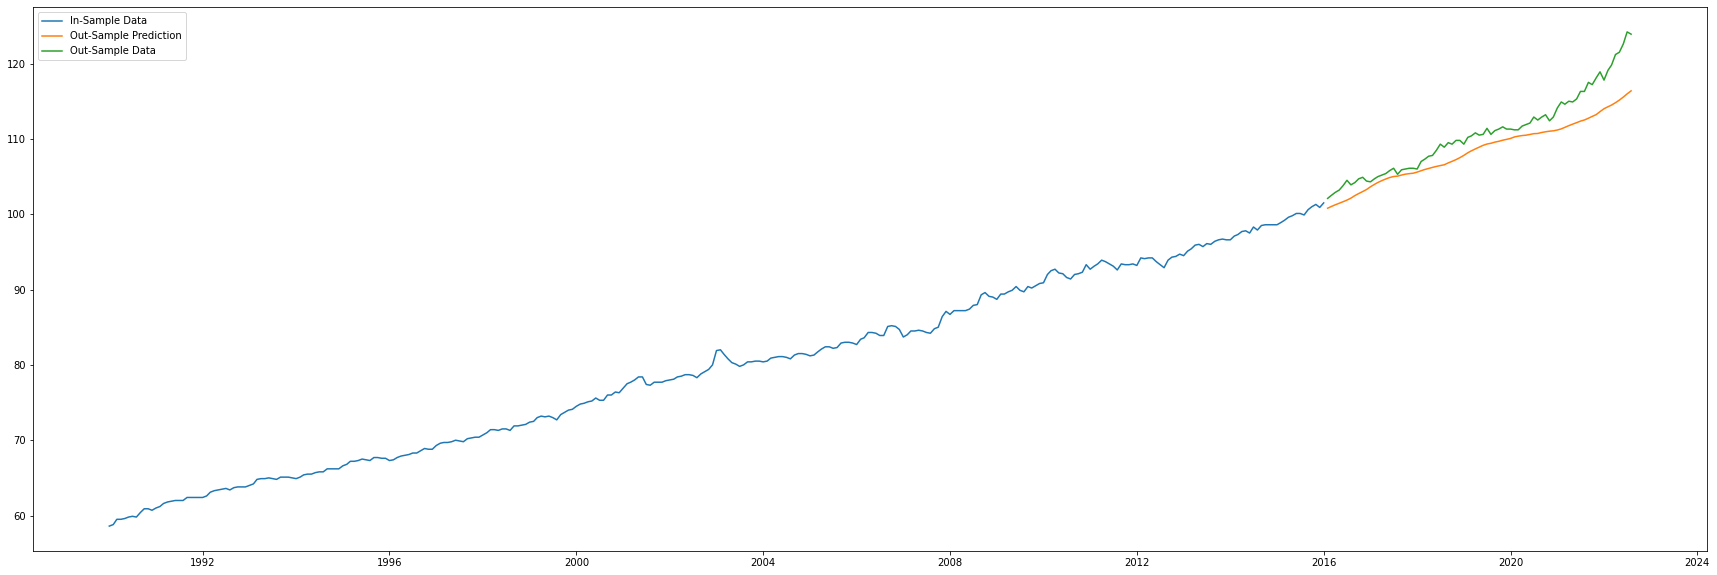

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(ts.index, ts, label='In-Sample Data')
plt.plot(preds.index, preds, label='Out-Sample Prediction')
plt.plot(ts_test.index, ts_test, label='Out-Sample Data')
plt.legend()
plt.show()

In [ ]:
metrics_summary(ts_test, preds)

MAPE: 0.020670211570949008
MAE: 2.349851564817791
MSE: 8.399231082556234
RMSE: 2.898142695340627
R2: 0.7104869303006427


The results achieved, using a Simple univariate Recurrent Neural Network with a unique GRU Layer with a forecast horizon of 1 and a maximum delay of 12 month before, are not great compared with other predicting achieved previously.

### Multivariate ML model

Now, it will be tested a ML model using the CPI index of US and the European Union as explanatory TS.

In [296]:
explanatory_ts = ['United States', 'European Union']

In [297]:
max_lag = 12
delays = range(1, max_lag + 1)

In [298]:
# split and normalize Data
X_train, X_val = train_test_split(train_data, shuffle=False, test_size=0.15)

scaler = MinMaxScaler()

normalized_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
normalized_val = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)
normalized_test = pd.DataFrame(scaler.transform(test_data), columns=X_train.columns)

In [299]:
# train data
train_delays = generate_IO_data(normalized_train[country], inData=normalized_train[explanatory_ts], delayEndog=delays, delayExog=[delays, delays])
train_input = train_delays.iloc[:, 0:-1]
train_output = np.array([train_delays.iloc[:, -1].to_numpy()]).T
train_input_tensor = generate_tensor(train_input, max_lag, 3)

(254, 12, 3)


In [300]:
# validation data
val = pd.concat([normalized_train.iloc[len(normalized_train)-max_lag:], normalized_val])
val_delays = generate_IO_data(val[country], inData=val[explanatory_ts], delayEndog=delays, delayExog=[delays, delays])
val_input = val_delays.iloc[:, 0:-1]
val_output = np.array([val_delays.iloc[:, -1].to_numpy()]).T
val_input_tensor = generate_tensor(val_input, max_lag, 3)

(47, 12, 3)


In [301]:
test = pd.concat([normalized_val.iloc[len(normalized_val)-max_lag:], normalized_test])
test_delays = generate_IO_data(test[country], inData=test[explanatory_ts], delayEndog=delays, delayExog=[delays, delays])
test_input = test_delays.iloc[:, 0:-1]
test_output = np.array([test_delays.iloc[:, -1].to_numpy()]).T
test_input_tensor = generate_tensor(test_input, max_lag, 3)

(79, 12, 3)


In [302]:
LATENT_DIM = 50
BATCH_SIZE = 8
EPOCHS = 100
HORIZON = 1

In [328]:
model = Sequential()
model.add(layers.GRU(LATENT_DIM, input_shape=(max_lag, 3)))
model.add(layers.Dense(HORIZON))

In [329]:
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50)                8250      
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8301 (32.43 KB)
Trainable params: 8301 (32.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [330]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 15
)

In [331]:
train_input_tensor.shape

(254, 12, 3)

In [332]:
train_output.shape

(254, 1)

In [333]:
history = model.fit(
    train_input_tensor,
    train_output,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (val_input_tensor, val_output),
    callbacks = [early_stopping],
    verbose=1
)

Epoch 1/100


32/32 [==============================] - 2s 27ms/step - loss: 0.0476 - val_loss: 0.0085
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 7.9741e-04 - val_loss: 0.0021
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 6.2306e-04 - val_loss: 0.0013
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 5.3087e-04 - val_loss: 0.0011
Epoch 6/100
32/32 [==============================] - 0s 12ms/step - loss: 5.1848e-04 - val_loss: 0.0013
Epoch 7/100
32/32 [==============================] - 0s 12ms/step - loss: 5.1220e-04 - val_loss: 0.0010
Epoch 8/100
32/32 [==============================] - 0s 12ms/step - loss: 5.2222e-04 - val_loss: 0.0012
Epoch 9/100
32/32 [==============================] - 0s 12ms/step - loss: 5.0749e-04 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 0s 12ms/step - loss: 5.0988e-0

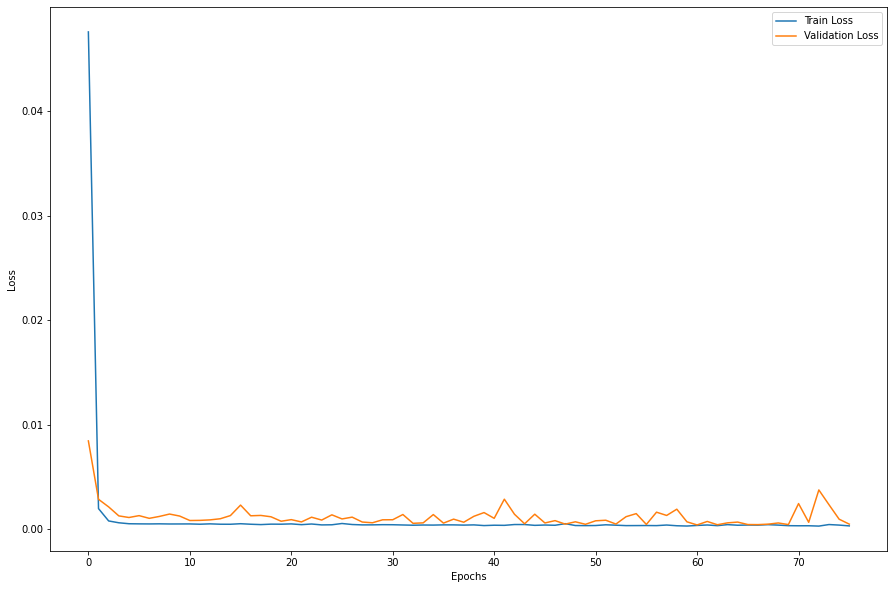

In [334]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [335]:
preds = pd.Series(scaler_ts.inverse_transform(model.predict(test_input_tensor))[:, 0], index=ts_test.index)

3/3 [==============================] - 0s 13ms/step


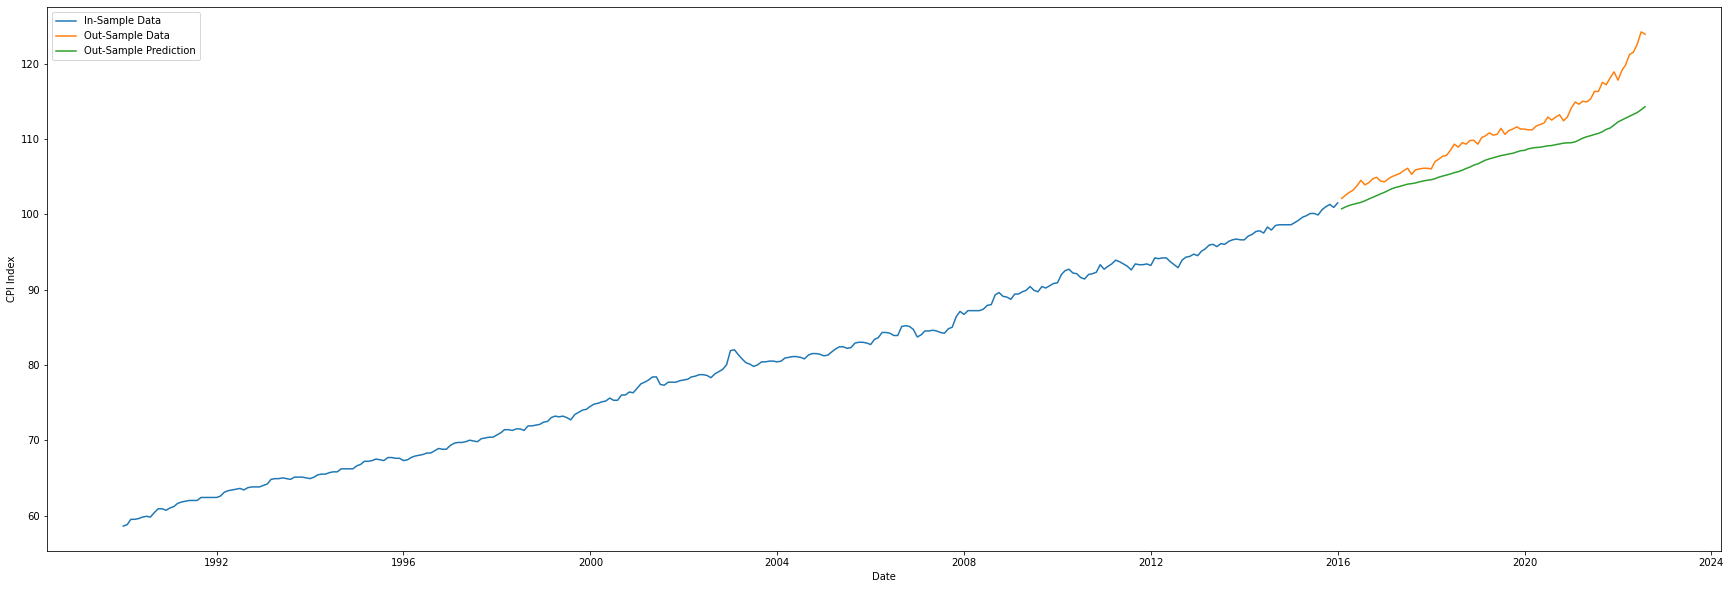

In [336]:
plt.figure(figsize=(30, 10))
plt.plot(ts.index, ts, label='In-Sample Data')
plt.plot(ts_test.index, ts_test, label='Out-Sample Data')
plt.plot(preds.index, preds, label='Out-Sample Prediction')
plt.legend()
plt.ylabel('CPI Index')
plt.xlabel('Date')
plt.show()

In [337]:
metrics_summary(ts_test, preds)

MAPE: 0.03177389179503064
MAE: 3.598836469046677
MSE: 17.074668857843935
RMSE: 4.132150633489047
R2: 0.4114532929804864
